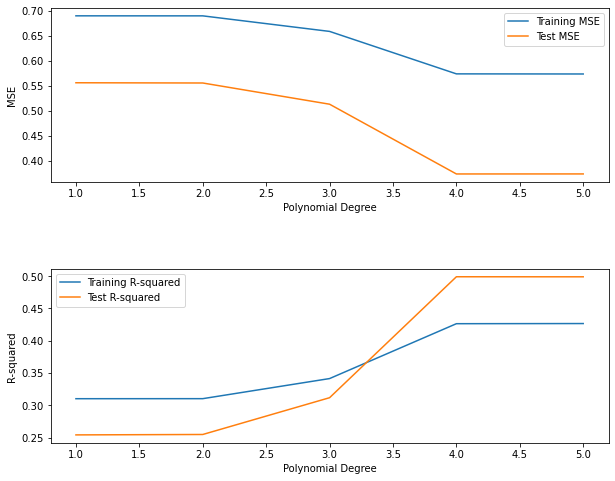

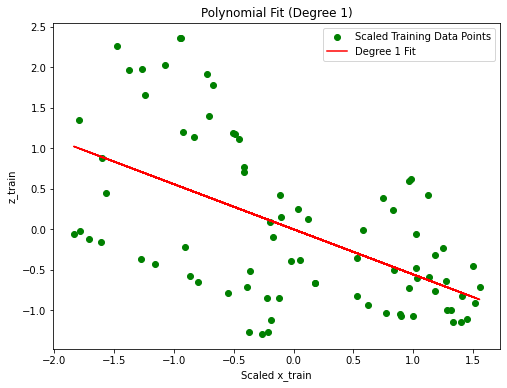

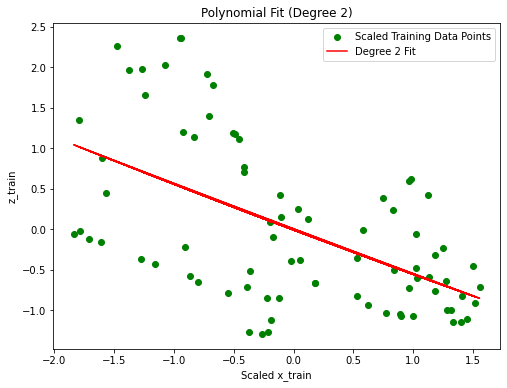

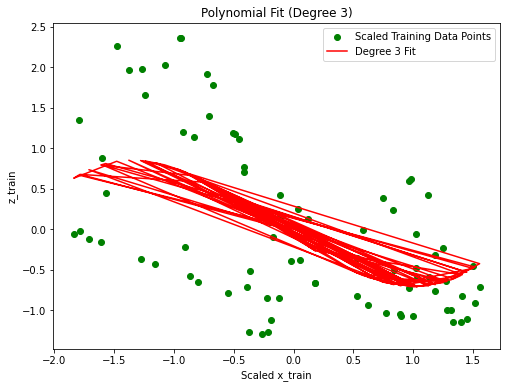

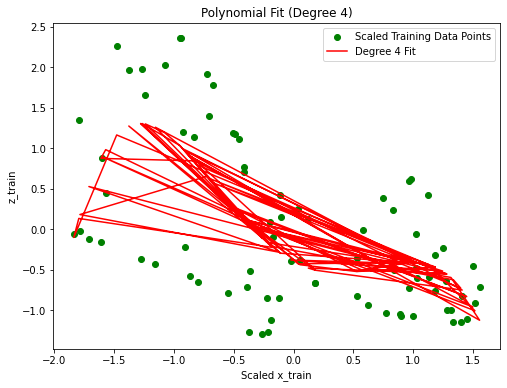

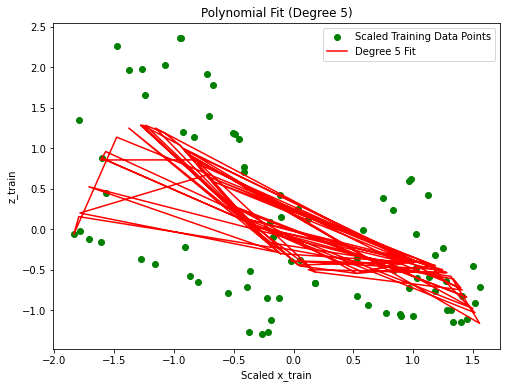

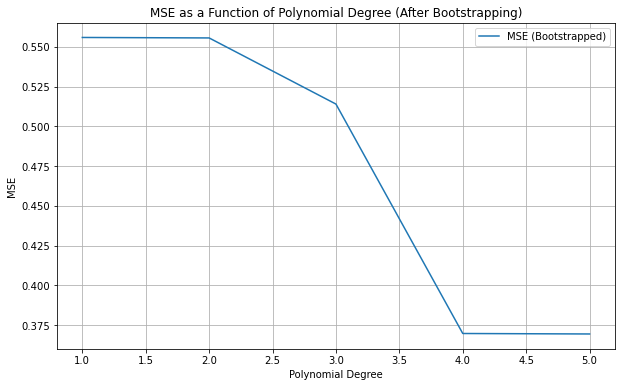

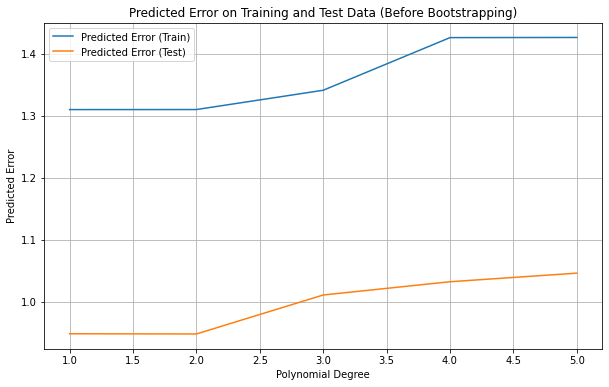

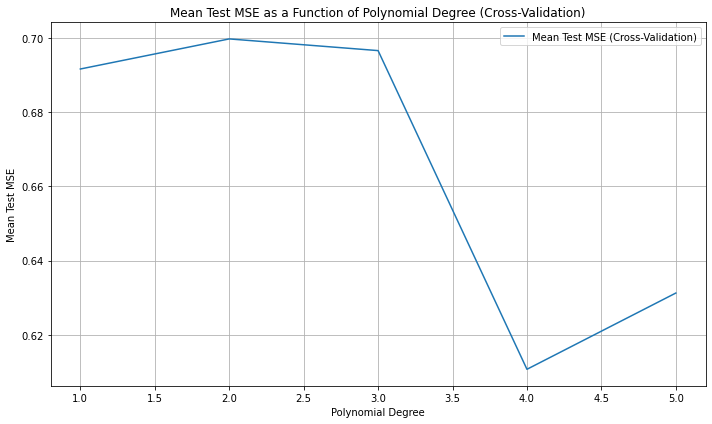

In [2]:
#Again OLS with Bootstrapping and Cross-Validation(5th time running Bootstrap)(10-folds): 

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
n = 100  # Adjust the number of data points as needed
x = np.random.rand(n)
y = np.random.rand(n)
z = FrankeFunction(x, y)

# Flatten the 1D arrays for data splitting
x_flat = x.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
z_flat = z.reshape(-1, 1)

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)
z_train_scaled = scaler.fit_transform(z_train)
z_test_scaled = scaler.transform(z_test)

# Initialize lists to store MSE and R-squared values for different degrees
degree_range = range(1, 6)
mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []

# Create subplots for the training and test error as a function of model complexity
fig, axs = plt.subplots(2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)

for degree in degree_range:
    # Create polynomial features for the current degree
    X_train = np.ones_like(x_train_scaled)
    X_test = np.ones_like(x_test_scaled)

    for d in range(1, degree + 1):
        X_train = np.hstack((X_train, x_train_scaled**d))
        X_test = np.hstack((X_test, x_test_scaled**d))

    model = LinearRegression()
    model.fit(X_train, z_train_scaled)

    z_train_pred = model.predict(X_train)
    z_test_pred = model.predict(X_test)

    # Calculate MSE and R-squared for training and test data
    mse_train = mean_squared_error(z_train_scaled, z_train_pred)
    mse_test = mean_squared_error(z_test_scaled, z_test_pred)
    r2_train = r2_score(z_train_scaled, z_train_pred)
    r2_test = r2_score(z_test_scaled, z_test_pred)

    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)

    # Plot the polynomial fits for scaled data points
    if degree <= 5:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_train_pred = model.predict(X_train)
        plt.plot(x_train_scaled, z_train_pred, color='red', label=f'Degree {degree} Fit')
        plt.xlabel('Scaled x_train')
        plt.ylabel('z_train')
        plt.legend()
        plt.title(f'Polynomial Fit (Degree {degree})')

# Plot training and test error as a function of model complexity (polynomial degree)
axs[0].plot(degree_range, mse_train_list, label='Training MSE')
axs[0].plot(degree_range, mse_test_list, label='Test MSE')
axs[0].set_xlabel('Polynomial Degree')
axs[0].set_ylabel('MSE')
axs[0].legend()

# Plot training and test R-squared as a function of model complexity (polynomial degree)
axs[1].plot(degree_range, r2_train_list, label='Training R-squared')
axs[1].plot(degree_range, r2_test_list, label='Test R-squared')
axs[1].set_xlabel('Polynomial Degree')
axs[1].set_ylabel('R-squared')
axs[1].legend()

# Perform Bootstrap Resampling for bias-variance analysis
n_bootstraps = 1000
max_degree = 5  # Maximum polynomial degree for MSE analysis
poly_degree = range(1, max_degree + 1)

# Initialize arrays to store MSE values
mse_bootstrapped = np.zeros(max_degree)

# Initialize arrays to store predictions
z_pred_bootstraps = np.empty((z_test_scaled.shape[0], n_bootstraps))

for degree in poly_degree:
    for i in range(n_bootstraps):
        # Generate bootstrap sample from training data
        indices = np.random.randint(0, x_train_scaled.shape[0], x_train_scaled.shape[0])
        x_bootstrap = x_train_scaled[indices]
        z_bootstrap = z_train_scaled[indices]

        # Create polynomial features for the current degree
        X_bootstrap = np.ones_like(x_bootstrap)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_bootstrap = np.hstack((X_bootstrap, x_bootstrap**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fit a linear regression model to the bootstrap sample
        model = LinearRegression()
        model.fit(X_bootstrap, z_bootstrap)

        # Make predictions on the test data
        z_pred = model.predict(X_test)

        # Store the predictions for MSE analysis
        z_pred_bootstraps[:, i] = z_pred.ravel()

    # Calculate MSE for the current degree
    mse_bootstrapped[degree - 1] = np.mean((z_test_scaled - np.mean(z_pred_bootstraps, axis=1, keepdims=True))**2)

# Plot MSE as a function of polynomial degree (after bootstrap)
plt.figure(figsize=(10, 6))
plt.plot(poly_degree, mse_bootstrapped, label='MSE (Bootstrapped)')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE as a Function of Polynomial Degree (After Bootstrapping)')
plt.grid(True)

# Calculate bias^2 and variance before bootstrap (using the same code as above without bootstrapping)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ... (Previous code for data generation, splitting, scaling, and degree range) ...

# Initialize arrays to store bias and variance values
bias_squared_train_before = np.zeros(max_degree)
variance_train_before = np.zeros(max_degree)
predicted_error_train_before = np.zeros(max_degree)

bias_squared_test_before = np.zeros(max_degree)
variance_test_before = np.zeros(max_degree)
predicted_error_test_before = np.zeros(max_degree)

for degree in poly_degree:
    # Create polynomial features for the current degree
    X_train = np.ones_like(x_train_scaled)
    X_test = np.ones_like(x_test_scaled)

    for d in range(1, degree + 1):
        X_train = np.hstack((X_train, x_train_scaled**d))
        X_test = np.hstack((X_test, x_test_scaled**d))

    model = LinearRegression()
    model.fit(X_train, z_train_scaled)

    z_train_pred = model.predict(X_train)
    z_test_pred = model.predict(X_test)

    # Calculate bias^2 for the current degree on training and test data
    bias_squared_train_before[degree - 1] = np.mean((z_train_scaled - np.mean(z_train_pred))**2)
    bias_squared_test_before[degree - 1] = np.mean((z_test_scaled - np.mean(z_test_pred))**2)

    # Calculate variance for the current degree on training and test data
    variance_train_before[degree - 1] = np.mean((z_train_pred - np.mean(z_train_pred))**2)
    variance_test_before[degree - 1] = np.mean((z_test_pred - np.mean(z_train_pred))**2)

    # Calculate predicted error as the sum of bias^2 and variance on training and test data
    predicted_error_train_before[degree - 1] = bias_squared_train_before[degree - 1] + variance_train_before[degree - 1]
    predicted_error_test_before[degree - 1] = bias_squared_test_before[degree - 1] + variance_test_before[degree - 1]

# Create a single plot for predicted error on both training and test data
plt.figure(figsize=(10, 6))
plt.plot(poly_degree, predicted_error_train_before, label='Predicted Error (Train)')
plt.plot(poly_degree, predicted_error_test_before, label='Predicted Error (Test)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Predicted Error')
plt.title('Predicted Error on Training and Test Data (Before Bootstrapping)')
plt.grid(True)
plt.legend()

# Now, add the code for k-fold cross-validation and MSE evaluation
# Define the number of folds for cross-validation
n_folds = 10  # You can adjust this as needed

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize a list to store MSE values for each fold
mse_values = []

# Iterate over the folds
for train_index, test_index in kf.split(x_flat):
    # Split the data into training and test sets for this fold
    x_train_cv, x_test_cv = x_flat[train_index], x_flat[test_index]
    y_train_cv, y_test_cv = y_flat[train_index], y_flat[test_index]
    z_train_cv, z_test_cv = z_flat[train_index], z_flat[test_index]

    # Scale the data using StandardScaler (you can reuse the scaler from your previous code)
    x_train_scaled_cv = scaler.transform(x_train_cv)
    x_test_scaled_cv = scaler.transform(x_test_cv)
    y_train_scaled_cv = scaler.transform(y_train_cv)
    y_test_scaled_cv = scaler.transform(y_test_cv)
    z_train_scaled_cv = scaler.transform(z_train_cv)
    z_test_scaled_cv = scaler.transform(z_test_cv)

    # Initialize lists to store MSE values for different degrees
    mse_train_list_cv = []
    mse_test_list_cv = []

    # Iterate over the polynomial degrees
    for degree in degree_range:
        # Create polynomial features for the current degree
        X_train_cv = np.ones_like(x_train_scaled_cv)
        X_test_cv = np.ones_like(x_test_scaled_cv)

        for d in range(1, degree + 1):
            X_train_cv = np.hstack((X_train_cv, x_train_scaled_cv**d))
            X_test_cv = np.hstack((X_test_cv, x_test_scaled_cv**d))

        # Fit a linear regression model to the training data
        model_cv = LinearRegression()
        model_cv.fit(X_train_cv, z_train_scaled_cv)

        # Make predictions on the training and test data
        z_train_pred_cv = model_cv.predict(X_train_cv)
        z_test_pred_cv = model_cv.predict(X_test_cv)

        # Calculate MSE for training and test data
        mse_train_cv = mean_squared_error(z_train_scaled_cv, z_train_pred_cv)
        mse_test_cv = mean_squared_error(z_test_scaled_cv, z_test_pred_cv)

        mse_train_list_cv.append(mse_train_cv)
        mse_test_list_cv.append(mse_test_cv)

    # Append the MSE value for the test data to the list for this fold
    mse_values.append(mse_test_list_cv)

# Calculate the mean MSE value across all folds for each degree
mean_mse_values = np.mean(mse_values, axis=0)

# Plot the mean MSE values as a function of polynomial degree
plt.figure(figsize=(10, 6))
plt.plot(degree_range, mean_mse_values, label='Mean Test MSE (Cross-Validation)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Test MSE')
plt.title('Mean Test MSE as a Function of Polynomial Degree (Cross-Validation)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#The test and training MSE are both decreasing in this case, with the 4th and 5th degree
#showing equal MSEs. The training MSE goes from 0.7 to 0.6, and the test MSE (checked in Bootstrapping
#and crossvalidation) from 0.56 to
#0.36. The test MSE has a big dropoff as degree increases.

#The MSE after bootstrapping gave a strictly decreasing graph beginning at 0.550
#and decreasing to 0.375.  
#The MSE after 10-folds cross validation gave an MSE beginning at 0.69, increasing to 0.7
#for the 2nd degree polynomial before dropping down to 0.61 for the 4th degree and
#0.63 for the 5th degree. The bootstrapping outperformed the crossvalidation in this case.


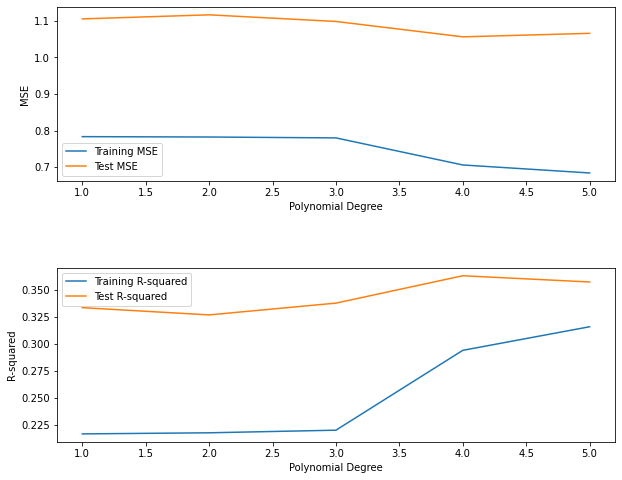

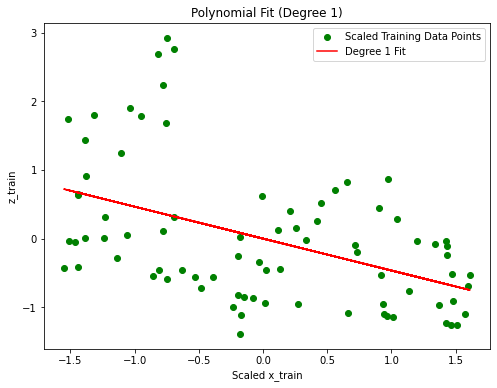

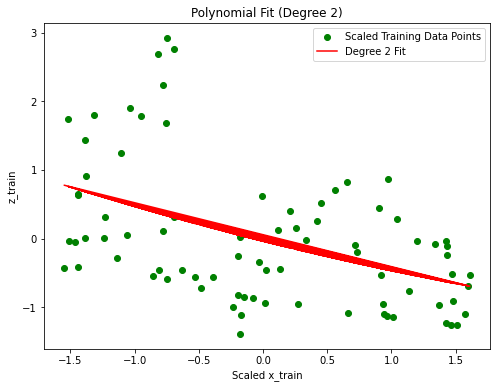

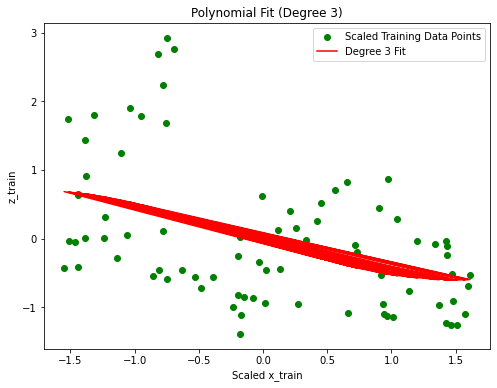

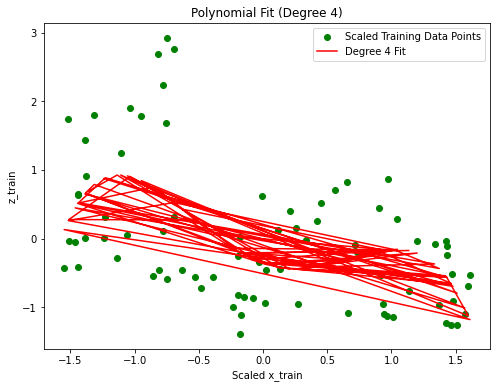

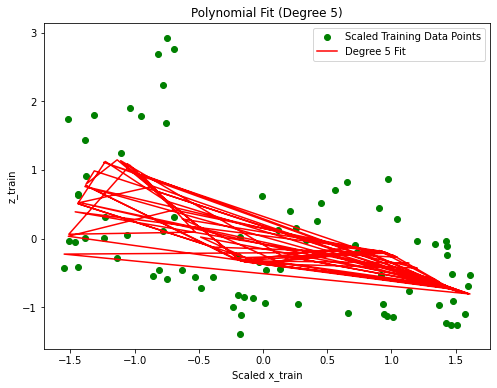

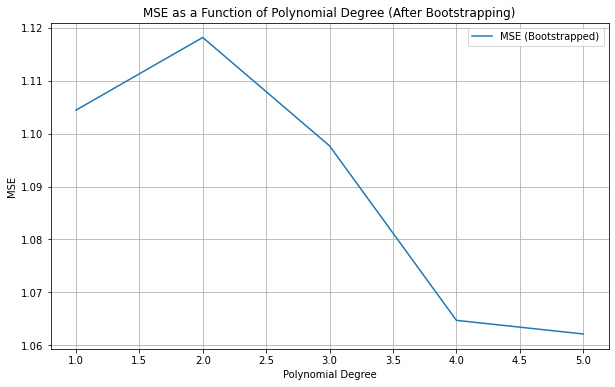

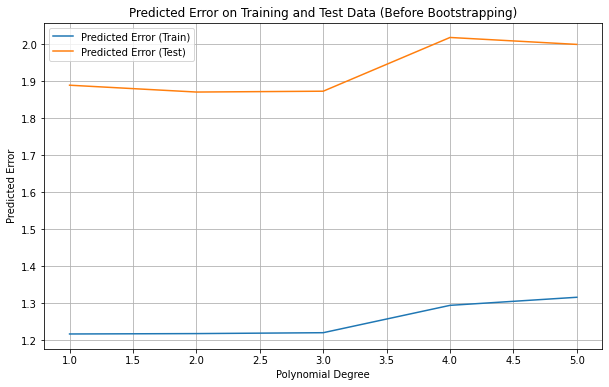

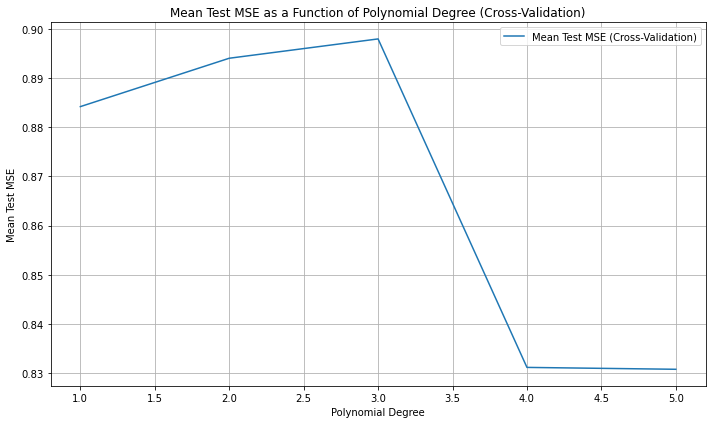

In [3]:
#Again OLS with Bootstrapping and Cross-Validation(6th time running Bootstrap)(10-folds): 

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
n = 100  # Adjust the number of data points as needed
x = np.random.rand(n)
y = np.random.rand(n)
z = FrankeFunction(x, y)

# Flatten the 1D arrays for data splitting
x_flat = x.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
z_flat = z.reshape(-1, 1)

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)
z_train_scaled = scaler.fit_transform(z_train)
z_test_scaled = scaler.transform(z_test)

# Initialize lists to store MSE and R-squared values for different degrees
degree_range = range(1, 6)
mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []

# Create subplots for the training and test error as a function of model complexity
fig, axs = plt.subplots(2, figsize=(10, 8))
fig.subplots_adjust(hspace=0.5)

for degree in degree_range:
    # Create polynomial features for the current degree
    X_train = np.ones_like(x_train_scaled)
    X_test = np.ones_like(x_test_scaled)

    for d in range(1, degree + 1):
        X_train = np.hstack((X_train, x_train_scaled**d))
        X_test = np.hstack((X_test, x_test_scaled**d))

    model = LinearRegression()
    model.fit(X_train, z_train_scaled)

    z_train_pred = model.predict(X_train)
    z_test_pred = model.predict(X_test)

    # Calculate MSE and R-squared for training and test data
    mse_train = mean_squared_error(z_train_scaled, z_train_pred)
    mse_test = mean_squared_error(z_test_scaled, z_test_pred)
    r2_train = r2_score(z_train_scaled, z_train_pred)
    r2_test = r2_score(z_test_scaled, z_test_pred)

    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)
    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)

    # Plot the polynomial fits for scaled data points
    if degree <= 5:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_train_pred = model.predict(X_train)
        plt.plot(x_train_scaled, z_train_pred, color='red', label=f'Degree {degree} Fit')
        plt.xlabel('Scaled x_train')
        plt.ylabel('z_train')
        plt.legend()
        plt.title(f'Polynomial Fit (Degree {degree})')

# Plot training and test error as a function of model complexity (polynomial degree)
axs[0].plot(degree_range, mse_train_list, label='Training MSE')
axs[0].plot(degree_range, mse_test_list, label='Test MSE')
axs[0].set_xlabel('Polynomial Degree')
axs[0].set_ylabel('MSE')
axs[0].legend()

# Plot training and test R-squared as a function of model complexity (polynomial degree)
axs[1].plot(degree_range, r2_train_list, label='Training R-squared')
axs[1].plot(degree_range, r2_test_list, label='Test R-squared')
axs[1].set_xlabel('Polynomial Degree')
axs[1].set_ylabel('R-squared')
axs[1].legend()

# Perform Bootstrap Resampling for bias-variance analysis
n_bootstraps = 1000
max_degree = 5  # Maximum polynomial degree for MSE analysis
poly_degree = range(1, max_degree + 1)

# Initialize arrays to store MSE values
mse_bootstrapped = np.zeros(max_degree)

# Initialize arrays to store predictions
z_pred_bootstraps = np.empty((z_test_scaled.shape[0], n_bootstraps))

for degree in poly_degree:
    for i in range(n_bootstraps):
        # Generate bootstrap sample from training data
        indices = np.random.randint(0, x_train_scaled.shape[0], x_train_scaled.shape[0])
        x_bootstrap = x_train_scaled[indices]
        z_bootstrap = z_train_scaled[indices]

        # Create polynomial features for the current degree
        X_bootstrap = np.ones_like(x_bootstrap)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_bootstrap = np.hstack((X_bootstrap, x_bootstrap**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fit a linear regression model to the bootstrap sample
        model = LinearRegression()
        model.fit(X_bootstrap, z_bootstrap)

        # Make predictions on the test data
        z_pred = model.predict(X_test)

        # Store the predictions for MSE analysis
        z_pred_bootstraps[:, i] = z_pred.ravel()

    # Calculate MSE for the current degree
    mse_bootstrapped[degree - 1] = np.mean((z_test_scaled - np.mean(z_pred_bootstraps, axis=1, keepdims=True))**2)

# Plot MSE as a function of polynomial degree (after bootstrap)
plt.figure(figsize=(10, 6))
plt.plot(poly_degree, mse_bootstrapped, label='MSE (Bootstrapped)')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.legend()
plt.title('MSE as a Function of Polynomial Degree (After Bootstrapping)')
plt.grid(True)

# Calculate bias^2 and variance before bootstrap (using the same code as above without bootstrapping)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ... (Previous code for data generation, splitting, scaling, and degree range) ...

# Initialize arrays to store bias and variance values
bias_squared_train_before = np.zeros(max_degree)
variance_train_before = np.zeros(max_degree)
predicted_error_train_before = np.zeros(max_degree)

bias_squared_test_before = np.zeros(max_degree)
variance_test_before = np.zeros(max_degree)
predicted_error_test_before = np.zeros(max_degree)

for degree in poly_degree:
    # Create polynomial features for the current degree
    X_train = np.ones_like(x_train_scaled)
    X_test = np.ones_like(x_test_scaled)

    for d in range(1, degree + 1):
        X_train = np.hstack((X_train, x_train_scaled**d))
        X_test = np.hstack((X_test, x_test_scaled**d))

    model = LinearRegression()
    model.fit(X_train, z_train_scaled)

    z_train_pred = model.predict(X_train)
    z_test_pred = model.predict(X_test)

    # Calculate bias^2 for the current degree on training and test data
    bias_squared_train_before[degree - 1] = np.mean((z_train_scaled - np.mean(z_train_pred))**2)
    bias_squared_test_before[degree - 1] = np.mean((z_test_scaled - np.mean(z_test_pred))**2)

    # Calculate variance for the current degree on training and test data
    variance_train_before[degree - 1] = np.mean((z_train_pred - np.mean(z_train_pred))**2)
    variance_test_before[degree - 1] = np.mean((z_test_pred - np.mean(z_train_pred))**2)

    # Calculate predicted error as the sum of bias^2 and variance on training and test data
    predicted_error_train_before[degree - 1] = bias_squared_train_before[degree - 1] + variance_train_before[degree - 1]
    predicted_error_test_before[degree - 1] = bias_squared_test_before[degree - 1] + variance_test_before[degree - 1]

# Create a single plot for predicted error on both training and test data
plt.figure(figsize=(10, 6))
plt.plot(poly_degree, predicted_error_train_before, label='Predicted Error (Train)')
plt.plot(poly_degree, predicted_error_test_before, label='Predicted Error (Test)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Predicted Error')
plt.title('Predicted Error on Training and Test Data (Before Bootstrapping)')
plt.grid(True)
plt.legend()

# Now, add the code for k-fold cross-validation and MSE evaluation
# Define the number of folds for cross-validation
n_folds = 10  # You can adjust this as needed

# Create a KFold object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize a list to store MSE values for each fold
mse_values = []

# Iterate over the folds
for train_index, test_index in kf.split(x_flat):
    # Split the data into training and test sets for this fold
    x_train_cv, x_test_cv = x_flat[train_index], x_flat[test_index]
    y_train_cv, y_test_cv = y_flat[train_index], y_flat[test_index]
    z_train_cv, z_test_cv = z_flat[train_index], z_flat[test_index]

    # Scale the data using StandardScaler (you can reuse the scaler from your previous code)
    x_train_scaled_cv = scaler.transform(x_train_cv)
    x_test_scaled_cv = scaler.transform(x_test_cv)
    y_train_scaled_cv = scaler.transform(y_train_cv)
    y_test_scaled_cv = scaler.transform(y_test_cv)
    z_train_scaled_cv = scaler.transform(z_train_cv)
    z_test_scaled_cv = scaler.transform(z_test_cv)

    # Initialize lists to store MSE values for different degrees
    mse_train_list_cv = []
    mse_test_list_cv = []

    # Iterate over the polynomial degrees
    for degree in degree_range:
        # Create polynomial features for the current degree
        X_train_cv = np.ones_like(x_train_scaled_cv)
        X_test_cv = np.ones_like(x_test_scaled_cv)

        for d in range(1, degree + 1):
            X_train_cv = np.hstack((X_train_cv, x_train_scaled_cv**d))
            X_test_cv = np.hstack((X_test_cv, x_test_scaled_cv**d))

        # Fit a linear regression model to the training data
        model_cv = LinearRegression()
        model_cv.fit(X_train_cv, z_train_scaled_cv)

        # Make predictions on the training and test data
        z_train_pred_cv = model_cv.predict(X_train_cv)
        z_test_pred_cv = model_cv.predict(X_test_cv)

        # Calculate MSE for training and test data
        mse_train_cv = mean_squared_error(z_train_scaled_cv, z_train_pred_cv)
        mse_test_cv = mean_squared_error(z_test_scaled_cv, z_test_pred_cv)

        mse_train_list_cv.append(mse_train_cv)
        mse_test_list_cv.append(mse_test_cv)

    # Append the MSE value for the test data to the list for this fold
    mse_values.append(mse_test_list_cv)

# Calculate the mean MSE value across all folds for each degree
mean_mse_values = np.mean(mse_values, axis=0)

# Plot the mean MSE values as a function of polynomial degree
plt.figure(figsize=(10, 6))
plt.plot(degree_range, mean_mse_values, label='Mean Test MSE (Cross-Validation)')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Test MSE')
plt.title('Mean Test MSE as a Function of Polynomial Degree (Cross-Validation)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#The test and training MSE are both decreasing in this case, though the test MSE slightly
#increases from degree 4 to 5. The training MSE goes from 0.8 to 0.7, and the test MSE (checked in Bootstrapping
#and crossvalidation) from 1.15 to
#1.08. The test MSE is quite high in this run.

#The test R2 begins at 0.325 and increases to about 0.36 for the 4th degree polynomial.
#This score is somewhat consistent with several earlier runs.
#The training R2 begins at 0.8 and decreases to about 0.7 for the 5th degree polynomial.

#The MSE after bootstrapping gave an increase from 1st to 2nd degree, and then
#a strict decrease from MSE=1.12 to MSE=1.075. This MSE is, like the original test MSE quite
#high.
#and decreasing to 0.375.  
#The MSE after 10-folds cross validation gave an MSE beginning at 0.88 for the 1st
#degree polynomial, increasing to 0.9 for the 3rd
#degree polynomial, before dropping to 0.83 for the 4th and 5th degree polynomial. 
#Unlike the previous run,
#the cross-validation outperformed the bootstrapping in this case.


C:\Users\chels\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.459e+01, tolerance: 3.200e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\chels\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.263e-01, tolerance: 3.200e-02
  model = cd_fast.enet_coordinate_descent(


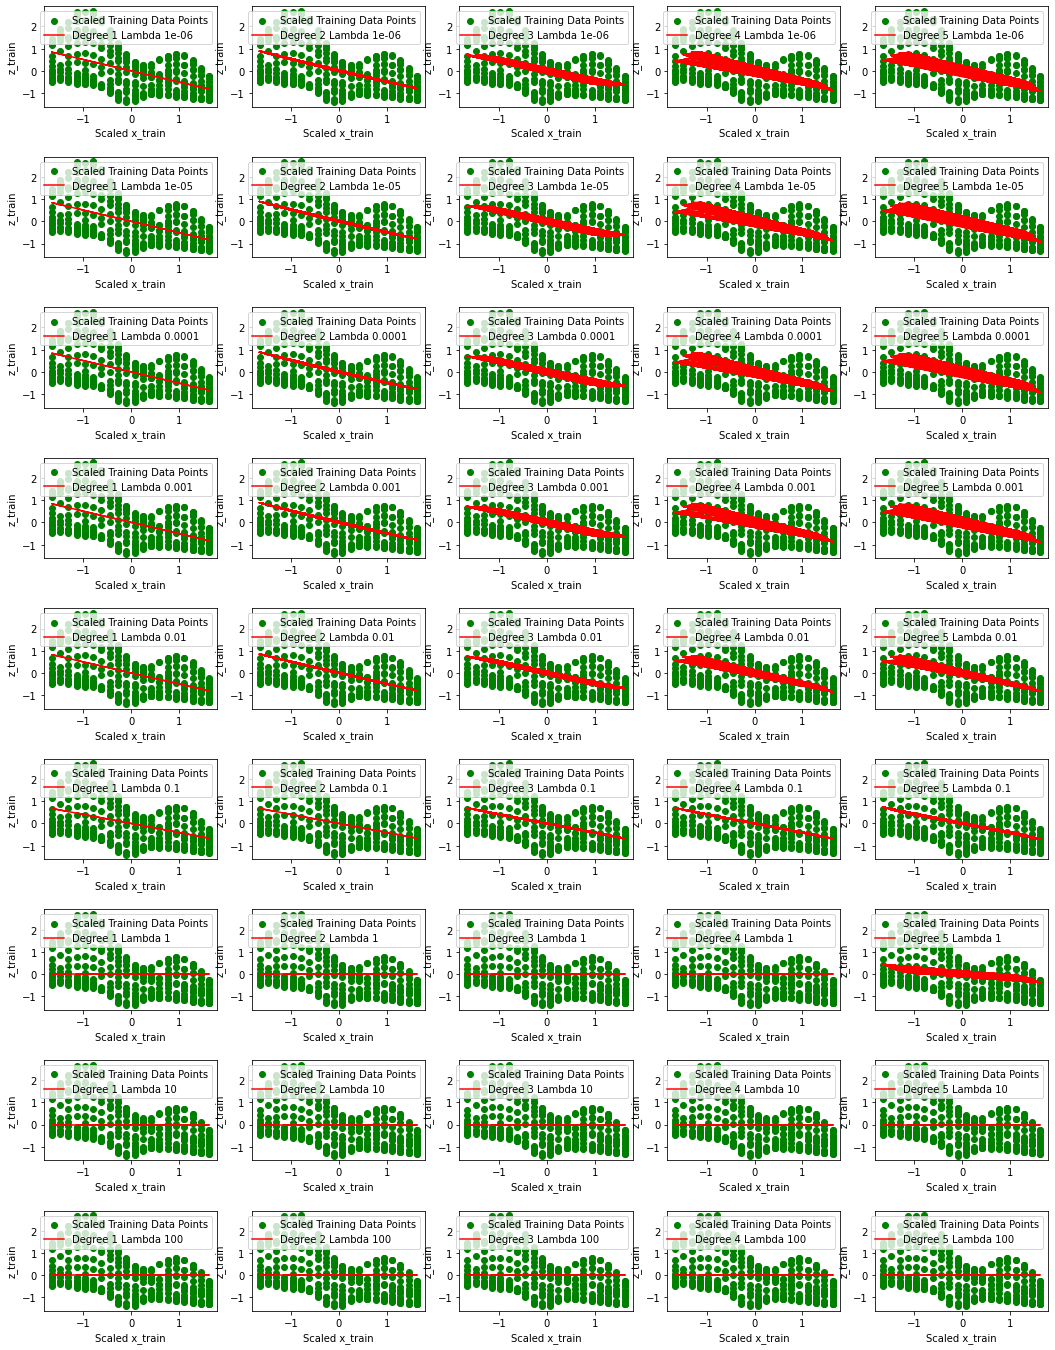

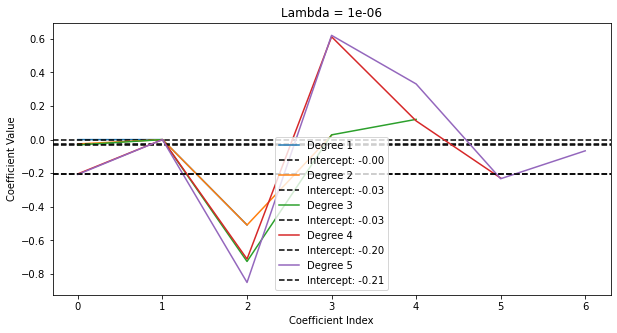

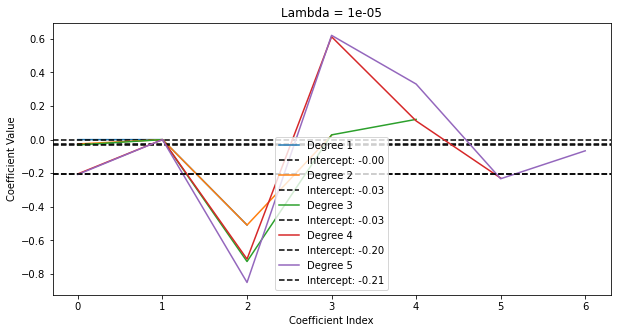

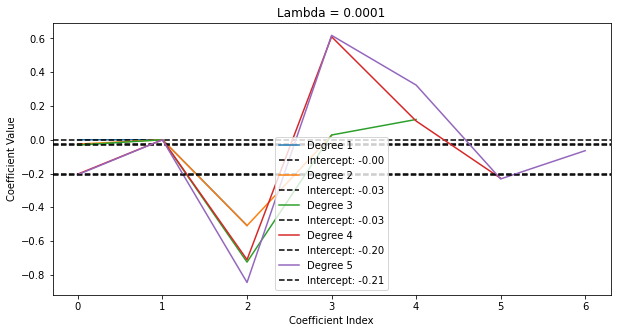

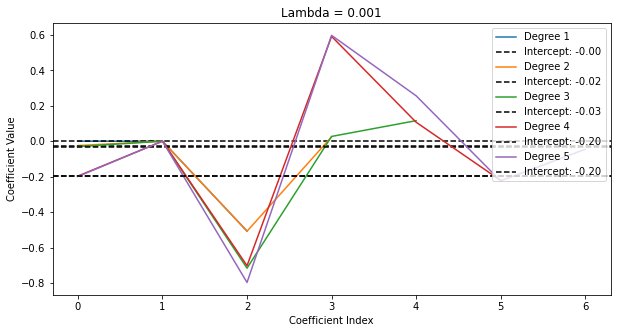

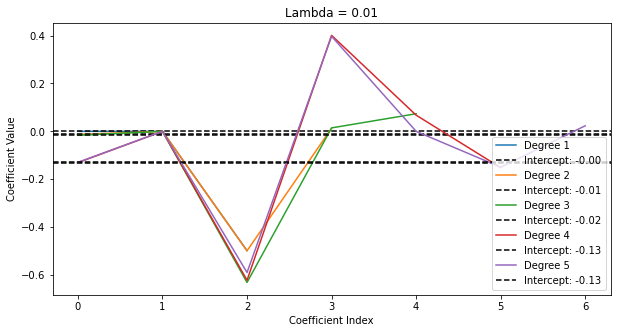

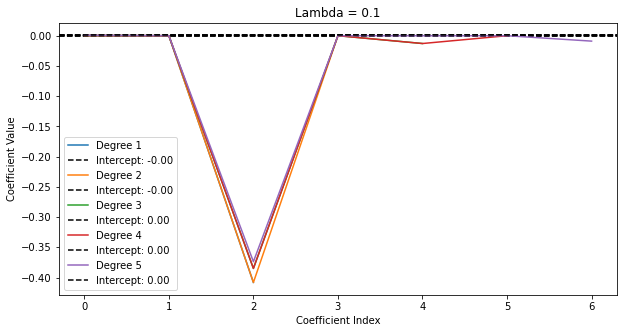

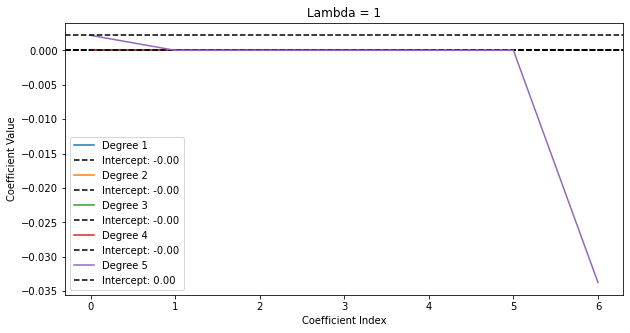

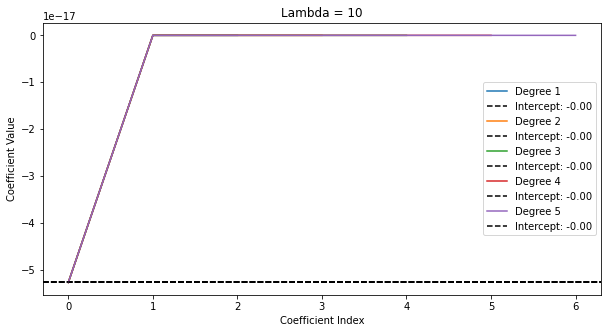

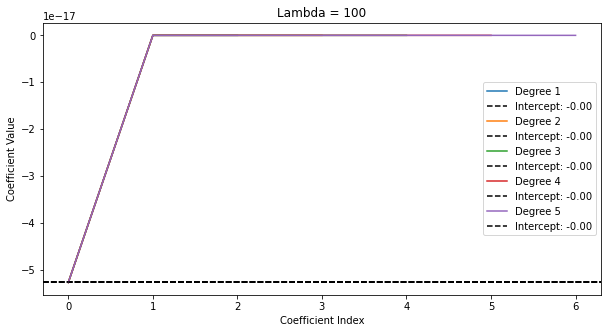

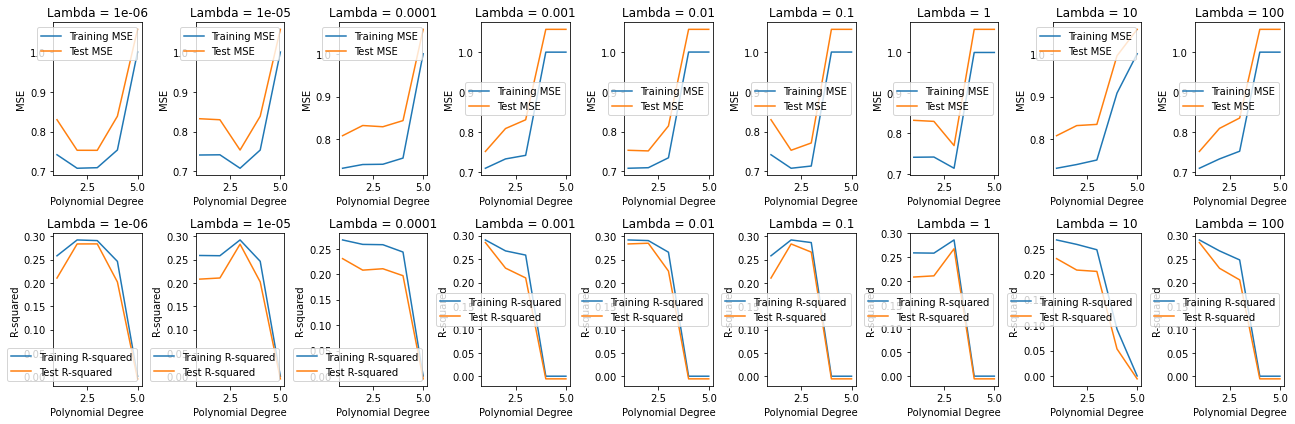

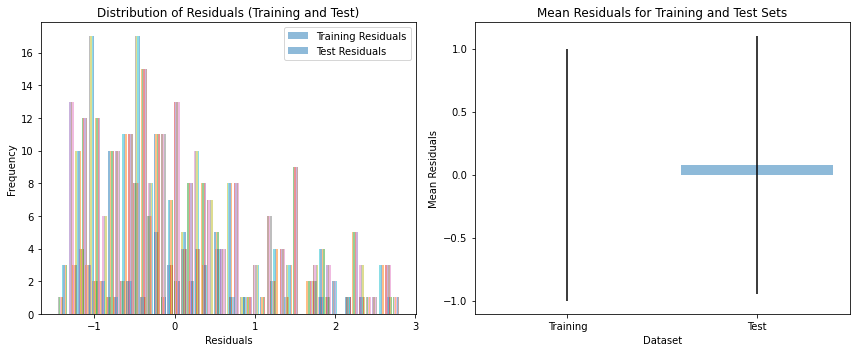

In [6]:
#The Lasso Regression with 9 different lambda values (Regularization strengths):
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)

# Flatten the 2D arrays for data splitting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler for both input features and target variable
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler_x.transform(x_test.reshape(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
z_train_scaled = scaler_y.fit_transform(z_train.reshape(-1, 1))  # Also standardize the target variable
z_test_scaled = scaler_y.transform(z_test.reshape(-1, 1))

# Initialize lists to store MSE and R-squared values for different degrees and lambda values (Lasso parameter)
degree_range = range(1, 6)
lambda_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
beta_coefficients_list = []

# Create subplots for the scaled training and test data
fig, axs = plt.subplots(len(lambda_values), len(degree_range), figsize=(18, 24))
fig.subplots_adjust(hspace=0.5)

for i, lambda_val in enumerate(lambda_values):
    for degree in degree_range:
        # Create polynomial features for the current degree
        X_train = np.ones_like(x_train_scaled)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_train = np.hstack((X_train, x_train_scaled**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fit Lasso regression model with the current lambda
        model = Lasso(alpha=lambda_val)
        model.fit(X_train, z_train_scaled)

        z_train_pred = model.predict(X_train)
        z_test_pred = model.predict(X_test)

        mse_train = mean_squared_error(z_train_scaled, z_train_pred)
        mse_test = mean_squared_error(z_test_scaled, z_test_pred)
        r2_train = r2_score(z_train_scaled, z_train_pred)
        r2_test = r2_score(z_test_scaled, z_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

        # Store beta coefficients, including the intercept
        beta_coeffs = np.insert(model.coef_, 0, model.intercept_)
        beta_coefficients_list.append(beta_coeffs)

        # Plot the scaled training and test data for each degree and lambda
        axs[i, degree - 1].scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_pred_train = model.predict(X_train)
        axs[i, degree - 1].plot(x_train_scaled, z_pred_train, color='red', label=f'Degree {degree} Lambda {lambda_val}')
        axs[i, degree - 1].set_xlabel('Scaled x_train')
        axs[i, degree - 1].set_ylabel('z_train')
        axs[i, degree - 1].legend()

# Plot beta coefficients for each lambda value and degree
for i, lambda_val in enumerate(lambda_values):
    plt.figure(figsize=(10, 5))
    for degree in degree_range:
        beta_coeffs_lasso = beta_coefficients_list[i * len(degree_range) + degree - 1]
        intercept = beta_coeffs_lasso[0]  # Intercept is at index 0
        plt.plot(range(len(beta_coeffs_lasso)), beta_coeffs_lasso, label=f'Degree {degree}')
        plt.axhline(y=intercept, color='black', linestyle='--', label=f'Intercept: {intercept:.2f}')
    plt.title(f'Lambda = {lambda_val}')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()

# MSE and R-squared plots
plt.figure(figsize=(18, 6))
for i, lambda_val in enumerate(lambda_values):
    plt.subplot(2, len(lambda_values), i + 1)
    plt.plot(degree_range, mse_train_list[i::len(lambda_values)], label='Training MSE')
    plt.plot(degree_range, mse_test_list[i::len(lambda_values)], label='Test MSE')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

    plt.subplot(2, len(lambda_values), len(lambda_values) + i + 1)
    plt.plot(degree_range, r2_train_list[i::len(lambda_values)], label='Training R-squared')
    plt.plot(degree_range, r2_test_list[i::len(lambda_values)], label='Test R-squared')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R-squared')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate and analyze error terms
residuals_train = z_train_scaled - z_train_pred
residuals_test = z_test_scaled - z_test_pred

# Calculate mean and standard deviation of residuals
mean_residuals_train = np.mean(residuals_train)
std_residuals_train = np.std(residuals_train)

mean_residuals_test = np.mean(residuals_test)
std_residuals_test = np.std(residuals_test)

# Plot histograms of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=50, label='Training Residuals', alpha=0.5)
plt.hist(residuals_test, bins=50, label='Test Residuals', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Residuals (Training and Test)')

plt.subplot(1, 2, 2)
plt.bar(['Training', 'Test'], [mean_residuals_train, mean_residuals_test], yerr=[std_residuals_train, std_residuals_test], alpha=0.5)
plt.xlabel('Dataset')
plt.ylabel('Mean Residuals')
plt.title('Mean Residuals for Training and Test Sets')

plt.tight_layout()
plt.show()

#With more lambda-values, the residuals were different. There were lower frequencies for different values but the spread was relatively
#equal to as before.


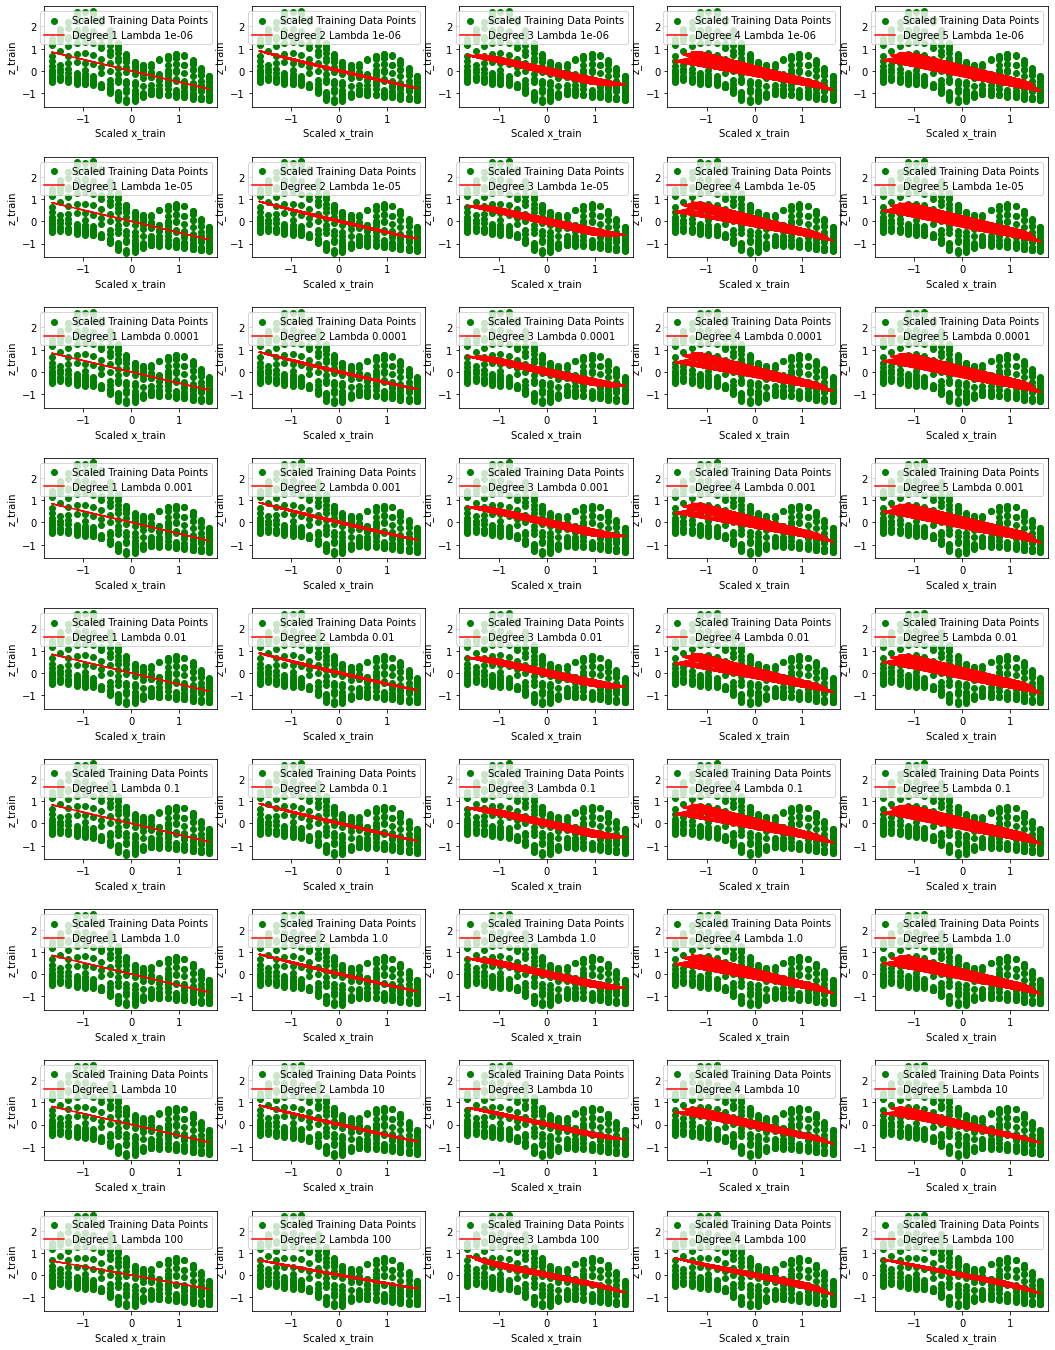

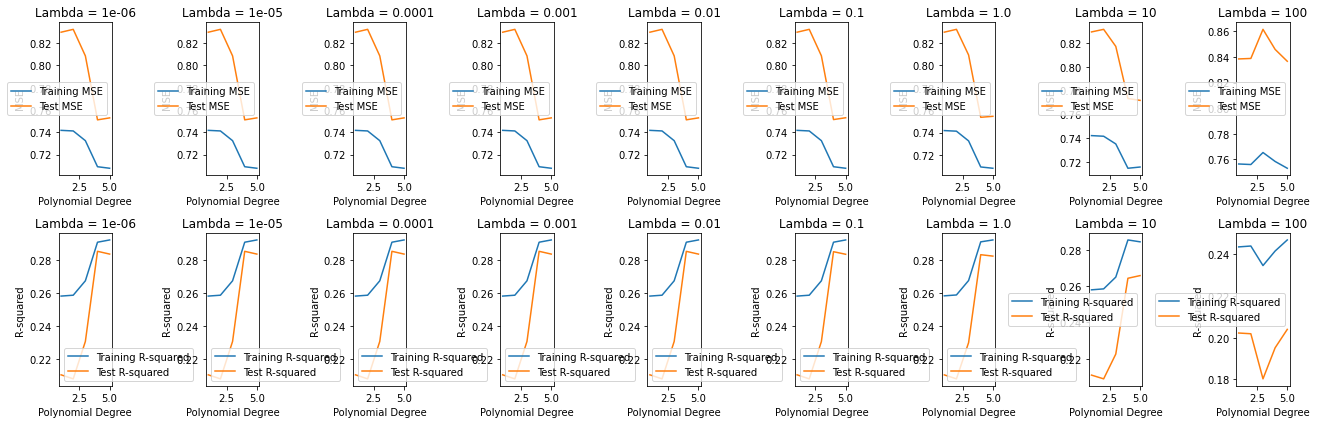

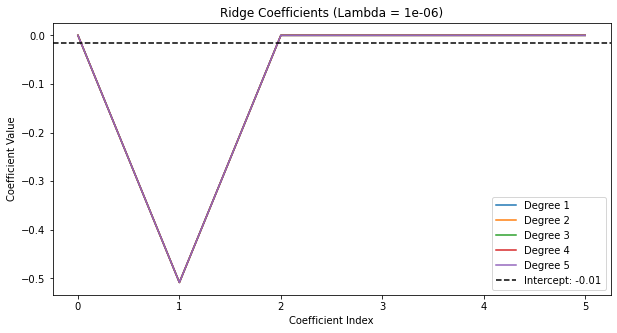

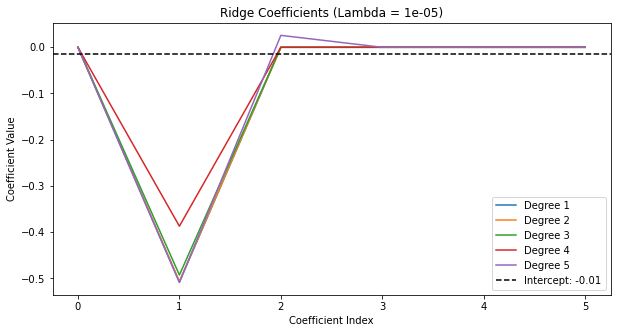

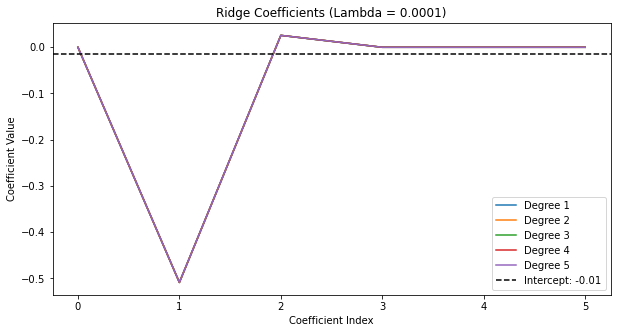

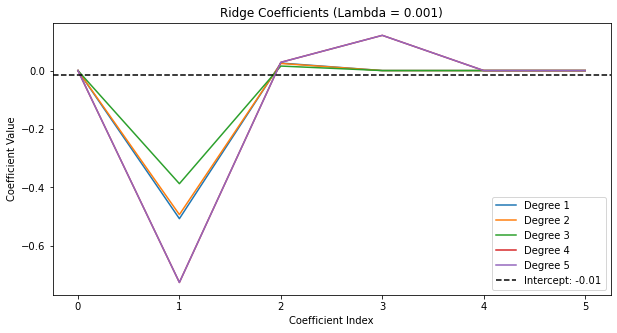

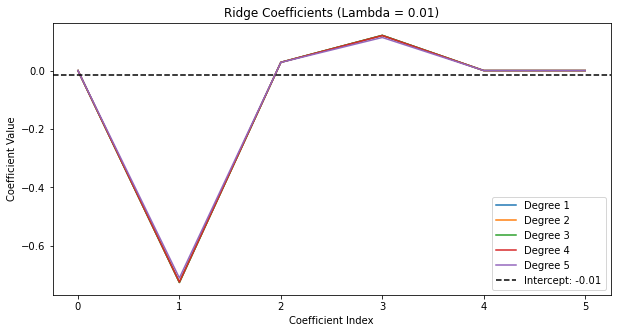

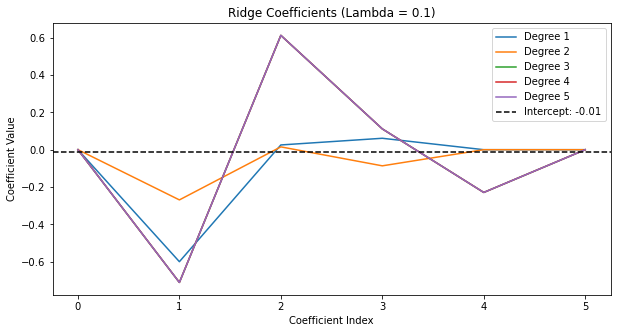

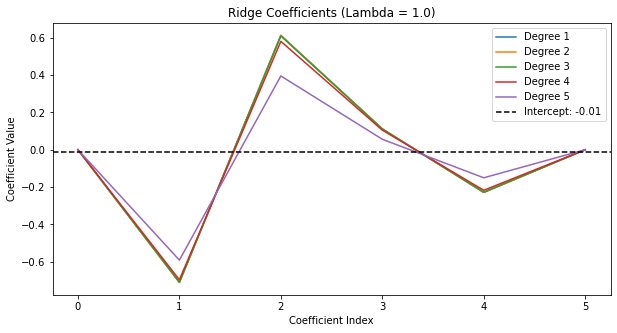

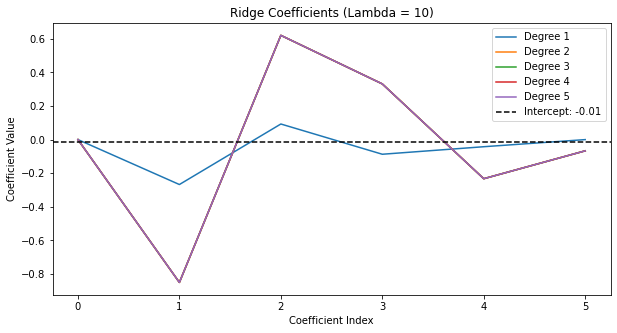

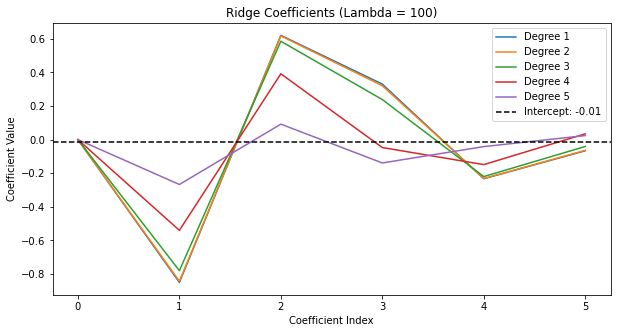

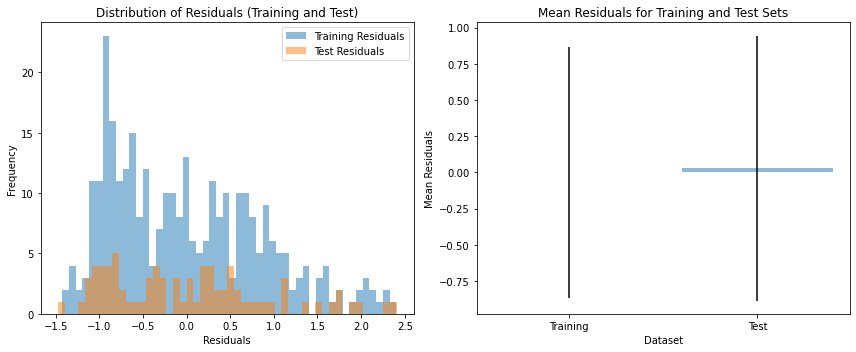

In [7]:
#Ridge regression w. the same 9 lambda values, also including polynomial fits: 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)

# Flatten the 2D arrays for data splitting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
z_train_scaled = scaler.fit_transform(z_train.reshape(-1, 1))
z_test_scaled = scaler.transform(z_test.reshape(-1, 1))

# Initialize lists to store MSE and R-squared values for different degrees and lambda values
degree_range = range(1, 6)
lambda_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
beta_coefficients_list = []

# Creates subplots for the scaled training and test data
fig, axs = plt.subplots(len(lambda_values), len(degree_range), figsize=(18, 24))
fig.subplots_adjust(hspace=0.5)

for degree in degree_range:
    for i, lambda_val in enumerate(lambda_values):
        # Creates polynomial features for the current degree
        X_train = np.ones_like(x_train_scaled)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_train = np.hstack((X_train, x_train_scaled**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fits Ridge regression model with the current lambda
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, z_train_scaled)

        z_train_pred = model.predict(X_train)
        z_test_pred = model.predict(X_test)

        mse_train = mean_squared_error(z_train_scaled, z_train_pred)
        mse_test = mean_squared_error(z_test_scaled, z_test_pred)
        r2_train = r2_score(z_train_scaled, z_train_pred)
        r2_test = r2_score(z_test_scaled, z_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

        # Store beta coefficients
        beta_coefficients_list.append(model.coef_.flatten())

        # Plot the scaled training and test data for each degree and lambda
        axs[i, degree - 1].scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_pred_train = model.predict(X_train)
        axs[i, degree - 1].plot(x_train_scaled, z_pred_train, color='red', label=f'Degree {degree} Lambda {lambda_val}')
        axs[i, degree - 1].set_xlabel('Scaled x_train')
        axs[i, degree - 1].set_ylabel('z_train')
        axs[i, degree - 1].legend()

# MSE and R-squared plots
plt.figure(figsize=(18, 6))
for i, lambda_val in enumerate(lambda_values):
    plt.subplot(2, len(lambda_values), i + 1)
    plt.plot(degree_range, mse_train_list[i::len(lambda_values)], label='Training MSE')
    plt.plot(degree_range, mse_test_list[i::len(lambda_values)], label='Test MSE')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

    plt.subplot(2, len(lambda_values), len(lambda_values) + i + 1)
    plt.plot(degree_range, r2_train_list[i::len(lambda_values)], label='Training R-squared')
    plt.plot(degree_range, r2_test_list[i::len(lambda_values)], label='Test R-squared')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R-squared')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

plt.tight_layout()

# Plots beta coefficients and intercepts
for i, lambda_val in enumerate(lambda_values):
    # Creates a list to store beta coefficients for each degree
    beta_degree_list = []

    for degree in degree_range:
        # Extracts beta coefficients for the current degree and lambda value (Ridge coefficients)
        beta_coeffs_ridge = beta_coefficients_list[i * len(degree_range) + degree - 1]

        # Ensures that each beta_coeffs_ridge array has length 6 (coefficients up to degree 5)
        beta_coeffs_ridge = np.pad(beta_coeffs_ridge, (0, max(0, 5 - len(beta_coeffs_ridge) + 1)), 'constant')

        # Plots beta coefficients for the current lambda and degree
        beta_degree_list.append(beta_coeffs_ridge)

    # Merges polynomial plots for the same lambda value
    plt.figure(figsize=(10, 5))
    for degree in degree_range:
        plt.plot(range(len(beta_degree_list[0])), beta_degree_list[degree - 1], label=f'Degree {degree}')

    # Plots intercept as a horizontal line
    intercept = model.intercept_[0]
    plt.axhline(y=intercept, color='black', linestyle='--', label=f'Intercept: {intercept:.2f}')
    plt.title(f'Ridge Coefficients (Lambda = {lambda_val})')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()

# Calculates and analyzes error terms (Residuals)
residuals_train = z_train_scaled - z_train_pred
residuals_test = z_test_scaled - z_test_pred

# Calculates mean and standard deviation of residuals
mean_residuals_train = np.mean(residuals_train)
std_residuals_train = np.std(residuals_train)

mean_residuals_test = np.mean(residuals_test)
std_residuals_test = np.std(residuals_test)

# Plots histograms of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=50, label='Training Residuals', alpha=0.5)
plt.hist(residuals_test, bins=50, label='Test Residuals', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Residuals (Training and Test)')

plt.subplot(1, 2, 2)
plt.bar(['Training', 'Test'], [mean_residuals_train, mean_residuals_test], yerr=[std_residuals_train, std_residuals_test], alpha=0.5)
plt.xlabel('Dataset')
plt.ylabel('Mean Residuals')
plt.title('Mean Residuals for Training and Test Sets')

plt.tight_layout()
plt.show()

#Comments: The polynomial fits didnt notably change until the lambda value became extremely high (100).
#The MSE changed alot more for lambda=100 than for the other lambda-values, across polynomial degrees, suggesting Ridge regression
#needs more regularization strength to alter the results.
#A bit interesting was that the Ridge Beta coefficients altered more for the lambda=0.00001 than for the smaller
#lambda=0.000001 and the larger lambda=0.0001.Similar things happened with other regularization strengths, and there was
#no notable between regularization strength size and spread in the results.
#Distribution of residuals displayed similar results to the Lasso, where the frequency per value decreased compared
#to the Ridge regression with fewer regularization strengths. 

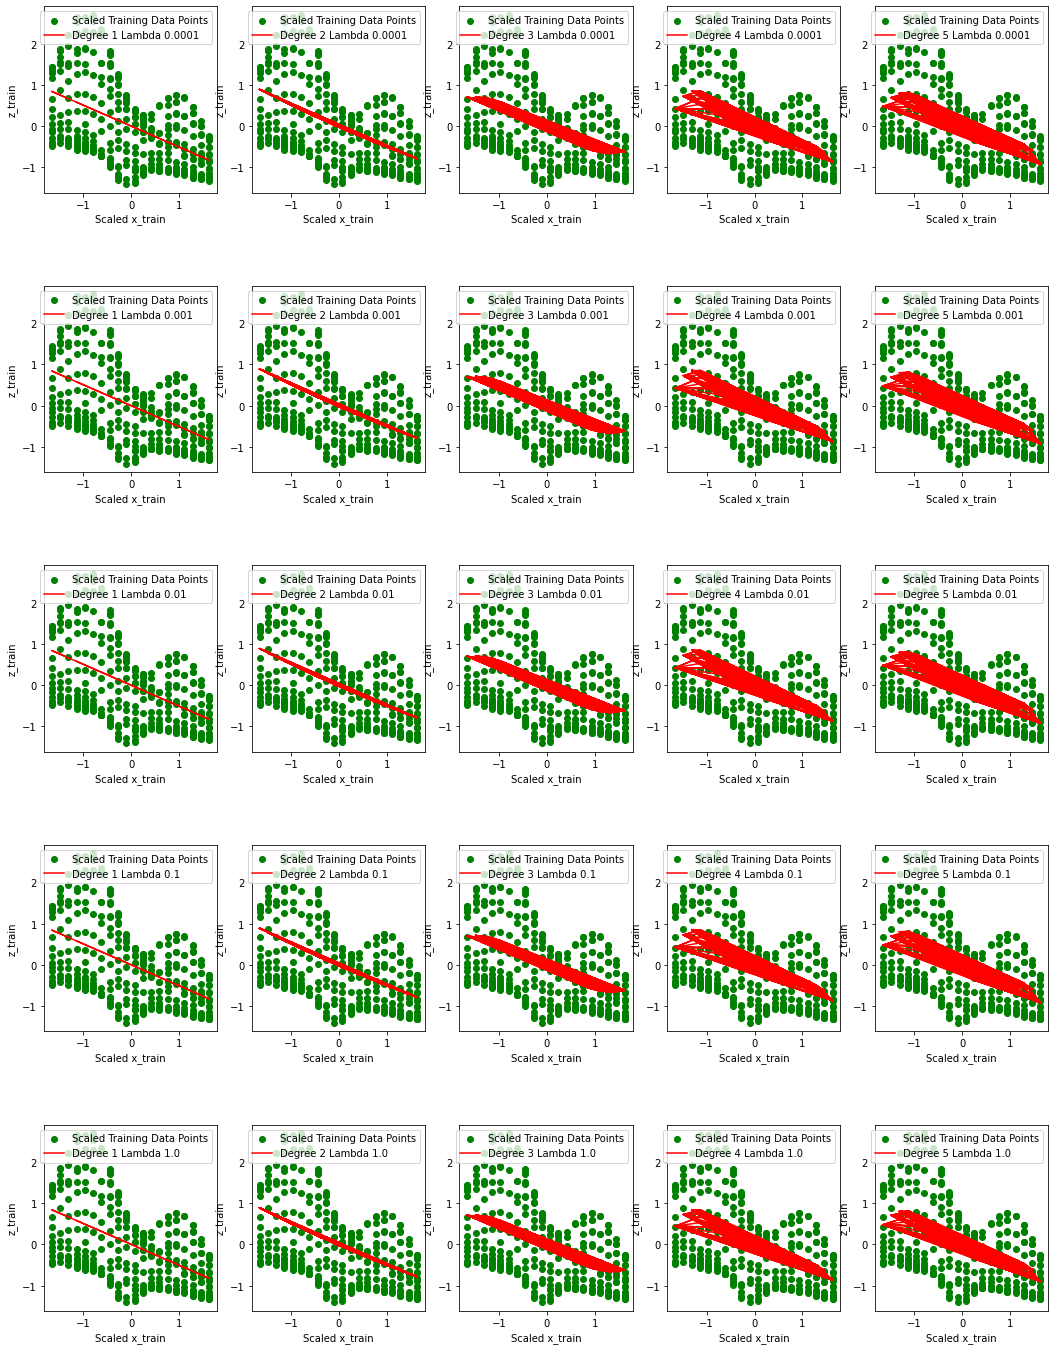

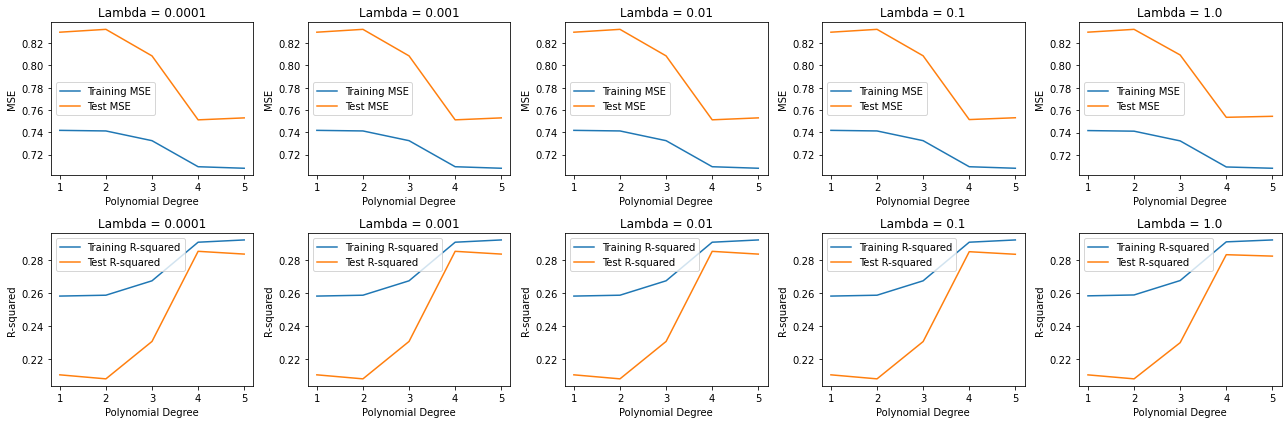

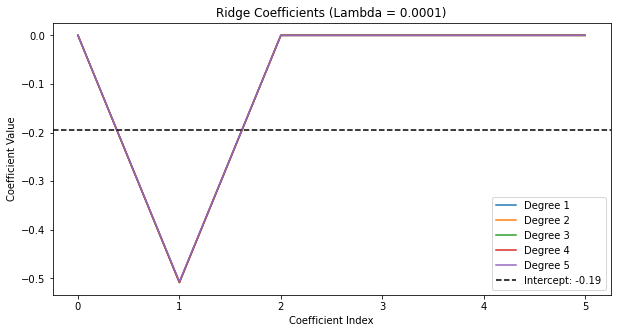

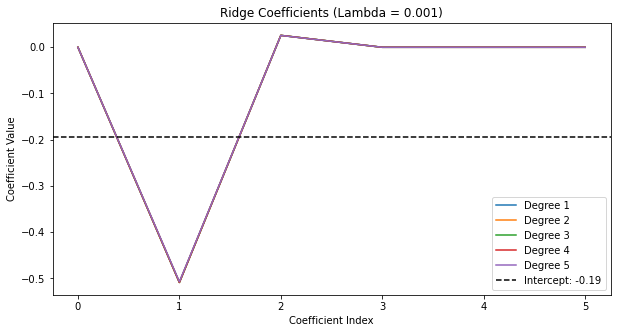

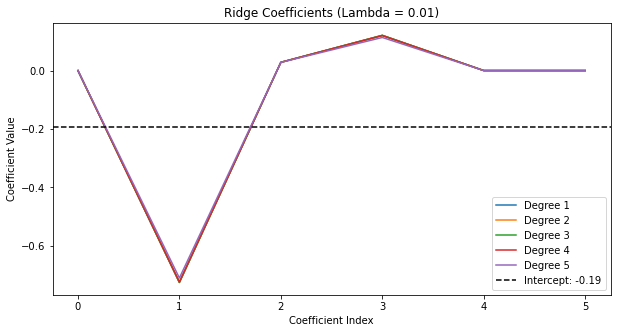

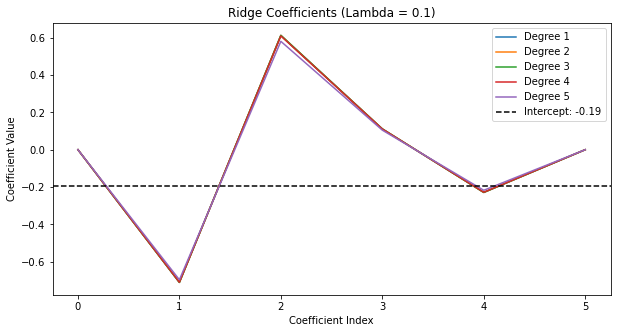

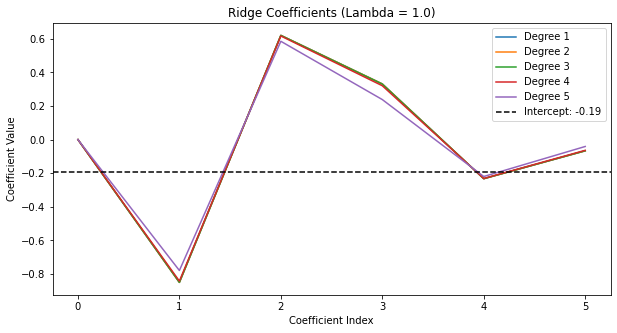

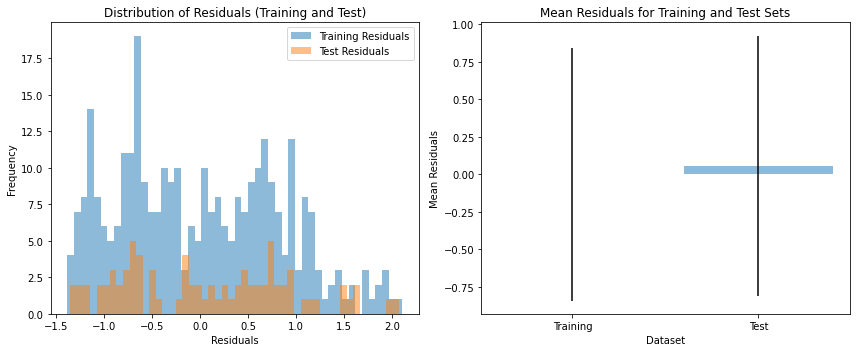

In [1]:
#Original code for Ridge includning polynomial fits for the Franke Function:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)

# Flatten the 2D arrays for data splitting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
z_train_scaled = scaler.fit_transform(z_train.reshape(-1, 1))
z_test_scaled = scaler.transform(z_test.reshape(-1, 1))

# Initialize lists to store MSE and R-squared values for different degrees and lambda values
degree_range = range(1, 6)
lambda_values = [0.0001, 0.001, 0.01, 0.1, 1.0]

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
beta_coefficients_list = []

# Creates subplots for the scaled training and test data
fig, axs = plt.subplots(len(lambda_values), len(degree_range), figsize=(18, 24))
fig.subplots_adjust(hspace=0.5)

for degree in degree_range:
    for i, lambda_val in enumerate(lambda_values):
        # Creates polynomial features for the current degree
        X_train = np.ones_like(x_train_scaled)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_train = np.hstack((X_train, x_train_scaled**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fits Ridge regression model with the current lambda
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, z_train_scaled)

        z_train_pred = model.predict(X_train)
        z_test_pred = model.predict(X_test)

        mse_train = mean_squared_error(z_train_scaled, z_train_pred)
        mse_test = mean_squared_error(z_test_scaled, z_test_pred)
        r2_train = r2_score(z_train_scaled, z_train_pred)
        r2_test = r2_score(z_test_scaled, z_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

        # Store beta coefficients
        beta_coefficients_list.append(model.coef_.flatten())

        # Plot the scaled training and test data for each degree and lambda
        axs[i, degree - 1].scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_pred_train = model.predict(X_train)
        axs[i, degree - 1].plot(x_train_scaled, z_pred_train, color='red', label=f'Degree {degree} Lambda {lambda_val}')
        axs[i, degree - 1].set_xlabel('Scaled x_train')
        axs[i, degree - 1].set_ylabel('z_train')
        axs[i, degree - 1].legend()

# MSE and R-squared plots
plt.figure(figsize=(18, 6))
for i, lambda_val in enumerate(lambda_values):
    plt.subplot(2, len(lambda_values), i + 1)
    plt.plot(degree_range, mse_train_list[i::len(lambda_values)], label='Training MSE')
    plt.plot(degree_range, mse_test_list[i::len(lambda_values)], label='Test MSE')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

    plt.subplot(2, len(lambda_values), len(lambda_values) + i + 1)
    plt.plot(degree_range, r2_train_list[i::len(lambda_values)], label='Training R-squared')
    plt.plot(degree_range, r2_test_list[i::len(lambda_values)], label='Test R-squared')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R-squared')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

plt.tight_layout()

# Plots beta coefficients and intercepts
for i, lambda_val in enumerate(lambda_values):
    # Creates a list to store beta coefficients for each degree
    beta_degree_list = []

    for degree in degree_range:
        # Extracts beta coefficients for the current degree and lambda value (Ridge coefficients)
        beta_coeffs_ridge = beta_coefficients_list[i * len(degree_range) + degree - 1]

        # Ensures that each beta_coeffs_ridge array has length 6 (coefficients up to degree 5)
        beta_coeffs_ridge = np.pad(beta_coeffs_ridge, (0, max(0, 5 - len(beta_coeffs_ridge) + 1)), 'constant')

        # Plots beta coefficients for the current lambda and degree
        beta_degree_list.append(beta_coeffs_ridge)

    # Merges polynomial plots for the same lambda value
    plt.figure(figsize=(10, 5))
    for degree in degree_range:
        plt.plot(range(len(beta_degree_list[0])), beta_degree_list[degree - 1], label=f'Degree {degree}')

    # Plots intercept as a horizontal line
    intercept = model.intercept_[0]
    plt.axhline(y=intercept, color='black', linestyle='--', label=f'Intercept: {intercept:.2f}')
    plt.title(f'Ridge Coefficients (Lambda = {lambda_val})')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()

# Calculates and analyzes error terms (Residuals)
residuals_train = z_train_scaled - z_train_pred
residuals_test = z_test_scaled - z_test_pred

# Calculates mean and standard deviation of residuals
mean_residuals_train = np.mean(residuals_train)
std_residuals_train = np.std(residuals_train)

mean_residuals_test = np.mean(residuals_test)
std_residuals_test = np.std(residuals_test)

# Plots histograms of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=50, label='Training Residuals', alpha=0.5)
plt.hist(residuals_test, bins=50, label='Test Residuals', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Residuals (Training and Test)')

plt.subplot(1, 2, 2)
plt.bar(['Training', 'Test'], [mean_residuals_train, mean_residuals_test], yerr=[std_residuals_train, std_residuals_test], alpha=0.5)
plt.xlabel('Dataset')
plt.ylabel('Mean Residuals')
plt.title('Mean Residuals for Training and Test Sets')

plt.tight_layout()
plt.show()

#Polynomial fit results: #Results: The Data Plots show that the predicted values have a bias for all values of lambda, and the amount of variance seems to depend on the polynomial degree,
#rather than the lambda-value. The variance in the predicted values is largely the same across all values of lambda, and interestingly,
#even though the variance increases as the polynomial degree increases, the largest variance is for the degree 4 polynomial,
#rather than the degree 5 polynomial, across all values of lambda. The variance seems to only marginally increase as the
#lambda value decreases, implying that the size of the regularization term is of relatively small importance to the 
#amount of bias and variance. However, the polynomial degree is of large importance, as the more complex model yields larger 
#bias and variance. 

#Comparing the Data Plots with the Data plots for OLS: The bias and variance in the polynomial fits that tries to emulate
#the real data is significantly smaller for all values of lambda,
#and polynomial degrees than the OLS method. The Ridge regression seems to take into account the model complexity, 
#but the variance does not strictly increase as model complexity increases, instead there is a small dropoff in variance 
#from degree 4 to degree 5.
#In the OLS method, the bias and variance stays the same for all degree polynomials, meaning the predicted values are not
#affected by model complexity. In the Ridge regression, they become increasingly scattered as the polynomial degree increases,
#but as mentioned experiences a small dropoff when polynomial degree increases from 4 to 5. 
#This tells us that our predicted values are closer to the mean (the real values) in this case,
#by using the Ridge regression method. 


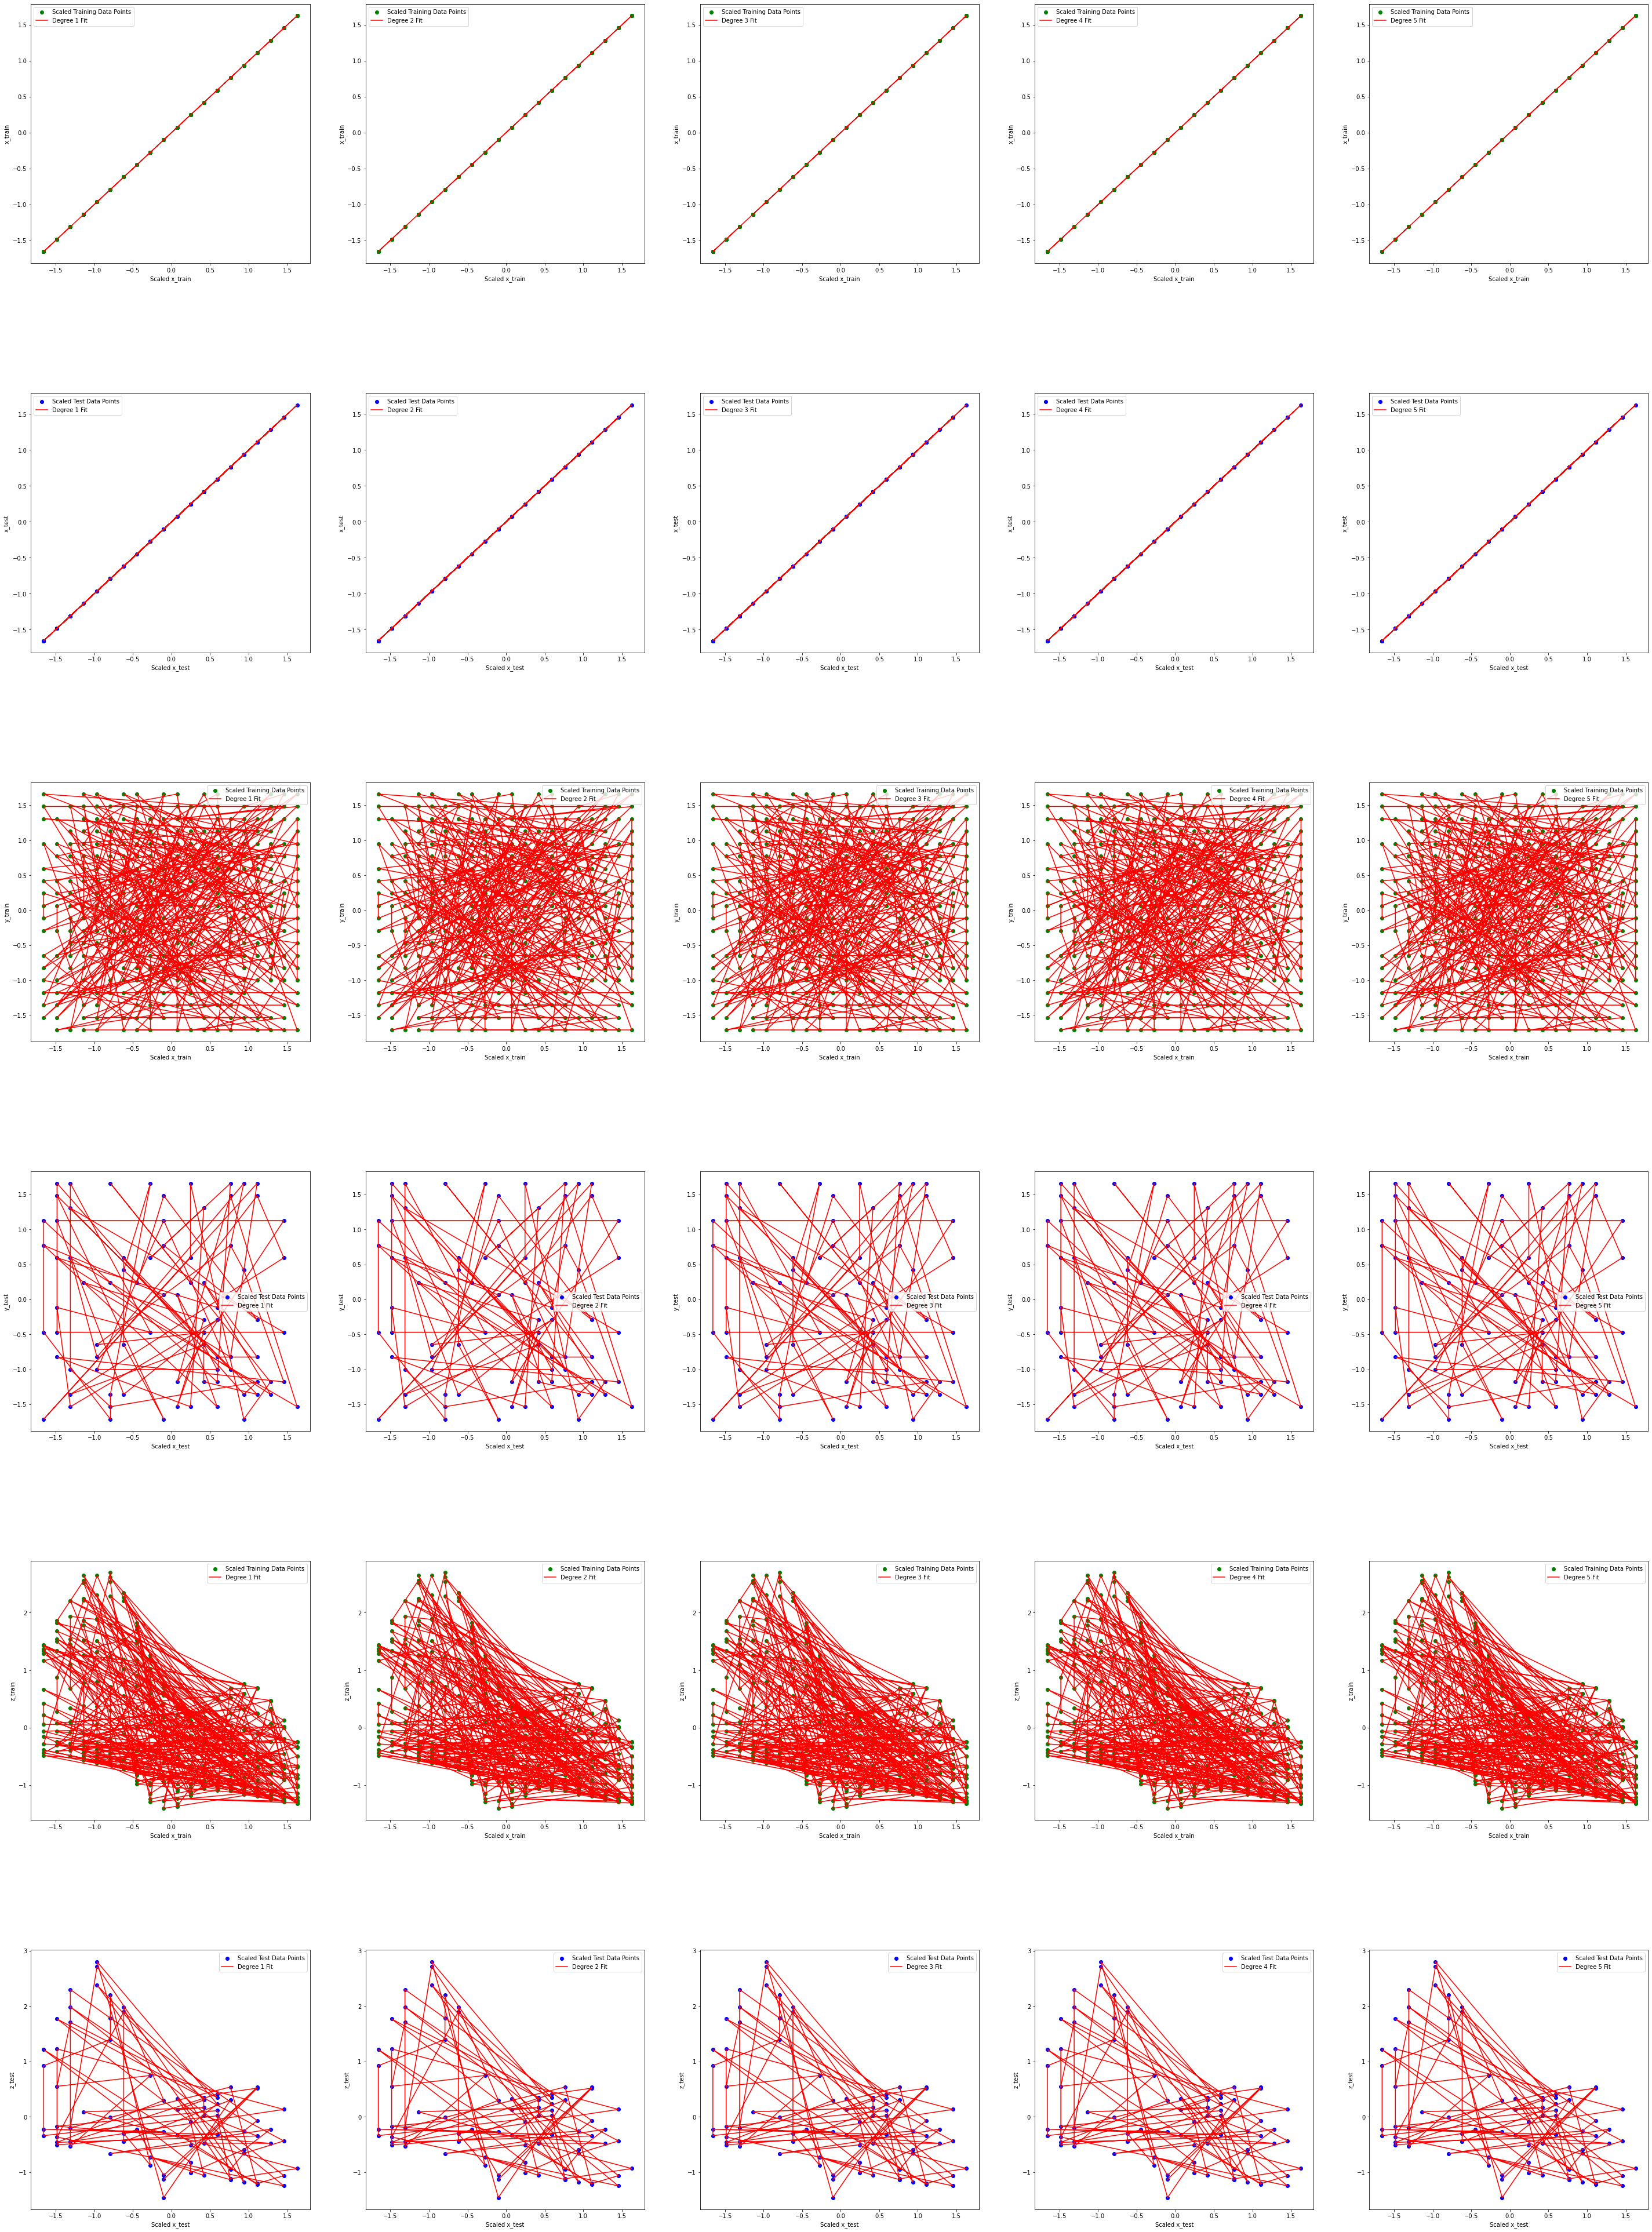

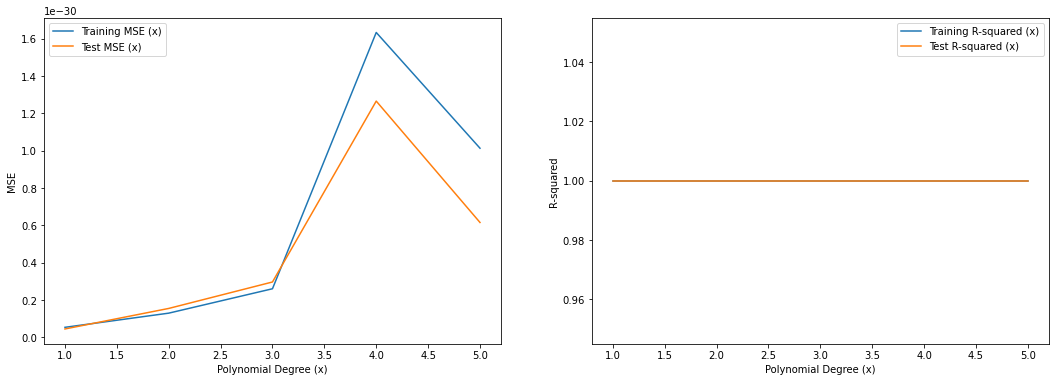

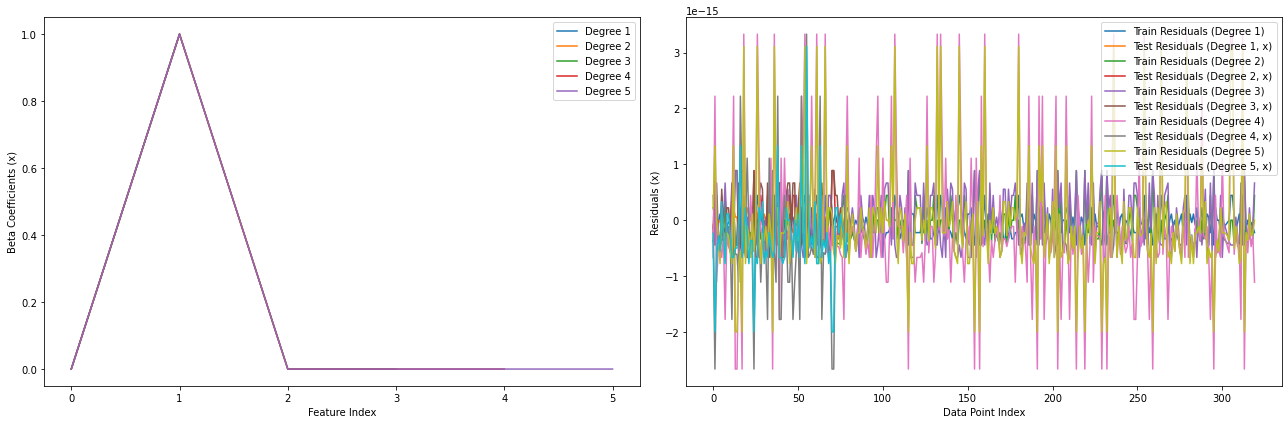

In [2]:
#Code including polynomial fits for the original OLS on the Franke Function:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)

# Flatten the 2D arrays for data splitting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
z_train_scaled = scaler.fit_transform(z_train.reshape(-1, 1))
z_test_scaled = scaler.transform(z_test.reshape(-1, 1))

# Initialize lists to store MSE and R-squared values for different degrees
degree_range = range(1, 6)
mse_train_list_x = []
mse_test_list_x = []
r2_train_list_x = []
r2_test_list_x = []
mse_train_list_y = []
mse_test_list_y = []
r2_train_list_y = []
r2_test_list_y = []
mse_train_list_z = []
mse_test_list_z = []
r2_train_list_z = []
r2_test_list_z = []

# Initialize lists to store residuals
residuals_train_x = []
residuals_test_x = []
residuals_train_y = []
residuals_test_y = []
residuals_train_z = []
residuals_test_z = []

# Create subplots for the scaled training and test data
fig, axs = plt.subplots(6, 5, figsize=(50, 70))  # Increase the figure size
fig.subplots_adjust(hspace=0.5)

for degree in degree_range:
    # Create polynomial features for the current degree
    X_train_x = np.ones_like(x_train_scaled)
    X_test_x = np.ones_like(x_test_scaled)
    X_train_y = np.ones_like(x_train_scaled)
    X_test_y = np.ones_like(x_test_scaled)
    X_train_z = np.ones_like(x_train_scaled)
    X_test_z = np.ones_like(x_test_scaled)

    for d in range(1, degree + 1):
        X_train_x = np.hstack((X_train_x, x_train_scaled**d))
        X_test_x = np.hstack((X_test_x, x_test_scaled**d))
        X_train_y = np.hstack((X_train_y, y_train_scaled**d))
        X_test_y = np.hstack((X_test_y, y_test_scaled**d))
        X_train_z = np.hstack((X_train_z, z_train_scaled**d))
        X_test_z = np.hstack((X_test_z, z_test_scaled**d))

    model_x = LinearRegression()
    model_y = LinearRegression()
    model_z = LinearRegression()
    model_x.fit(X_train_x, x_train_scaled)
    model_y.fit(X_train_y, y_train_scaled)
    model_z.fit(X_train_z, z_train_scaled)

    x_train_pred_x = model_x.predict(X_train_x)
    x_test_pred_x = model_x.predict(X_test_x)
    y_train_pred_y = model_y.predict(X_train_y)
    y_test_pred_y = model_y.predict(X_test_y)
    z_train_pred_z = model_z.predict(X_train_z)
    z_test_pred_z = model_z.predict(X_test_z)

    # Calculate residuals
    residuals_train_x.append(x_train_scaled - x_train_pred_x)
    residuals_test_x.append(x_test_scaled - x_test_pred_x)
    residuals_train_y.append(y_train_scaled - y_train_pred_y)
    residuals_test_y.append(y_test_scaled - y_test_pred_y)
    residuals_train_z.append(z_train_scaled - z_train_pred_z)
    residuals_test_z.append(z_test_scaled - z_test_pred_z)

    mse_train_x = mean_squared_error(x_train_scaled, x_train_pred_x)
    mse_test_x = mean_squared_error(x_test_scaled, x_test_pred_x)
    r2_train_x = r2_score(x_train_scaled, x_train_pred_x)
    r2_test_x = r2_score(x_test_scaled, x_test_pred_x)
    
    mse_train_y = mean_squared_error(y_train_scaled, y_train_pred_y)
    mse_test_y = mean_squared_error(y_test_scaled, y_test_pred_y)
    r2_train_y = r2_score(y_train_scaled, y_train_pred_y)
    r2_test_y = r2_score(y_test_scaled, y_test_pred_y)
    
    mse_train_z = mean_squared_error(z_train_scaled, z_train_pred_z)
    mse_test_z = mean_squared_error(z_test_scaled, z_test_pred_z)
    r2_train_z = r2_score(z_train_scaled, z_train_pred_z)
    r2_test_z = r2_score(z_test_scaled, z_test_pred_z)

    mse_train_list_x.append(mse_train_x)
    mse_test_list_x.append(mse_test_x)
    r2_train_list_x.append(r2_train_x)
    r2_test_list_x.append(r2_test_x)
    
    mse_train_list_y.append(mse_train_y)
    mse_test_list_y.append(mse_test_y)
    r2_train_list_y.append(r2_train_y)
    r2_test_list_y.append(r2_test_y)
    
    mse_train_list_z.append(mse_train_z)
    mse_test_list_z.append(mse_test_z)
    r2_train_list_z.append(r2_train_z)
    r2_test_list_z.append(r2_test_z)

    # Plot the scaled training and test data for each degree
    axs[0, degree - 1].scatter(x_train_scaled, x_train_scaled, label='Scaled Training Data Points', color='green')
    x_pred_train_x = model_x.predict(X_train_x)
    axs[0, degree - 1].plot(x_train_scaled, x_pred_train_x, color='red', label=f'Degree {degree} Fit')
    axs[0, degree - 1].set_xlabel('Scaled x_train')
    axs[0, degree - 1].set_ylabel('x_train')
    axs[0, degree - 1].legend()

    axs[1, degree - 1].scatter(x_test_scaled, x_test_scaled, label='Scaled Test Data Points', color='blue')
    x_pred_test_x = model_x.predict(X_test_x)
    axs[1, degree - 1].plot(x_test_scaled, x_pred_test_x, color='red', label=f'Degree {degree} Fit')
    axs[1, degree - 1].set_xlabel('Scaled x_test')
    axs[1, degree - 1].set_ylabel('x_test')
    axs[1, degree - 1].legend()

    axs[2, degree - 1].scatter(x_train_scaled, y_train_scaled, label='Scaled Training Data Points', color='green')
    y_pred_train_y = model_y.predict(X_train_y)
    axs[2, degree - 1].plot(x_train_scaled, y_pred_train_y, color='red', label=f'Degree {degree} Fit')
    axs[2, degree - 1].set_xlabel('Scaled x_train')
    axs[2, degree - 1].set_ylabel('y_train')
    axs[2, degree - 1].legend()

    axs[3, degree - 1].scatter(x_test_scaled, y_test_scaled, label='Scaled Test Data Points', color='blue')
    y_pred_test_y = model_y.predict(X_test_y)
    axs[3, degree - 1].plot(x_test_scaled, y_pred_test_y, color='red', label=f'Degree {degree} Fit')
    axs[3, degree - 1].set_xlabel('Scaled x_test')
    axs[3, degree - 1].set_ylabel('y_test')
    axs[3, degree - 1].legend()

    axs[4, degree - 1].scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
    z_pred_train_z = model_z.predict(X_train_z)
    axs[4, degree - 1].plot(x_train_scaled, z_pred_train_z, color='red', label=f'Degree {degree} Fit')
    axs[4, degree - 1].set_xlabel('Scaled x_train')
    axs[4, degree - 1].set_ylabel('z_train')
    axs[4, degree - 1].legend()

    axs[5, degree - 1].scatter(x_test_scaled, z_test_scaled, label='Scaled Test Data Points', color='blue')
    z_pred_test_z = model_z.predict(X_test_z)
    axs[5, degree - 1].plot(x_test_scaled, z_pred_test_z, color='red', label=f'Degree {degree} Fit')
    axs[5, degree - 1].set_xlabel('Scaled x_test')
    axs[5, degree - 1].set_ylabel('z_test')
    axs[5, degree - 1].legend()

# MSE plot for x, y, and z
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(degree_range, mse_train_list_x, label='Training MSE (x)')
plt.plot(degree_range, mse_test_list_x, label='Test MSE (x)')
plt.xlabel('Polynomial Degree (x)')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(degree_range, r2_train_list_x, label='Training R-squared (x)')
plt.plot(degree_range, r2_test_list_x, label='Test R-squared (x)')
plt.xlabel('Polynomial Degree (x)')
plt.ylabel('R-squared')
plt.legend()

beta_coefficients_x = []

# Create subplots for the beta coefficients
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)

for degree in degree_range:
    # Create polynomial features for the current degree
    X_train_x = np.ones_like(x_train_scaled)
    for d in range(1, degree + 1):
        X_train_x = np.hstack((X_train_x, x_train_scaled**d))

    model_x = LinearRegression()
    model_x.fit(X_train_x, x_train_scaled)
    
    beta_coeff_x = model_x.coef_.ravel()  # Extract beta coefficients
    beta_coefficients_x.append(beta_coeff_x)

# Plot beta coefficients for each degree
for i in range(len(degree_range)):
    plt.plot(range(len(beta_coefficients_x[i])), beta_coefficients_x[i], label=f'Degree {degree_range[i]}')
plt.xlabel('Feature Index')
plt.ylabel('Beta Coefficients (x)')
plt.legend()

# Residuals plot for x
plt.subplot(1, 2, 2)
for i, degree in enumerate(degree_range):
    plt.plot(range(len(residuals_train_x[i])), residuals_train_x[i], label=f'Train Residuals (Degree {degree})')
    plt.plot(range(len(residuals_test_x[i])), residuals_test_x[i], label=f'Test Residuals (Degree {degree}, x)')
plt.xlabel('Data Point Index')
plt.ylabel('Residuals (x)')
plt.legend()

plt.tight_layout()
plt.show()

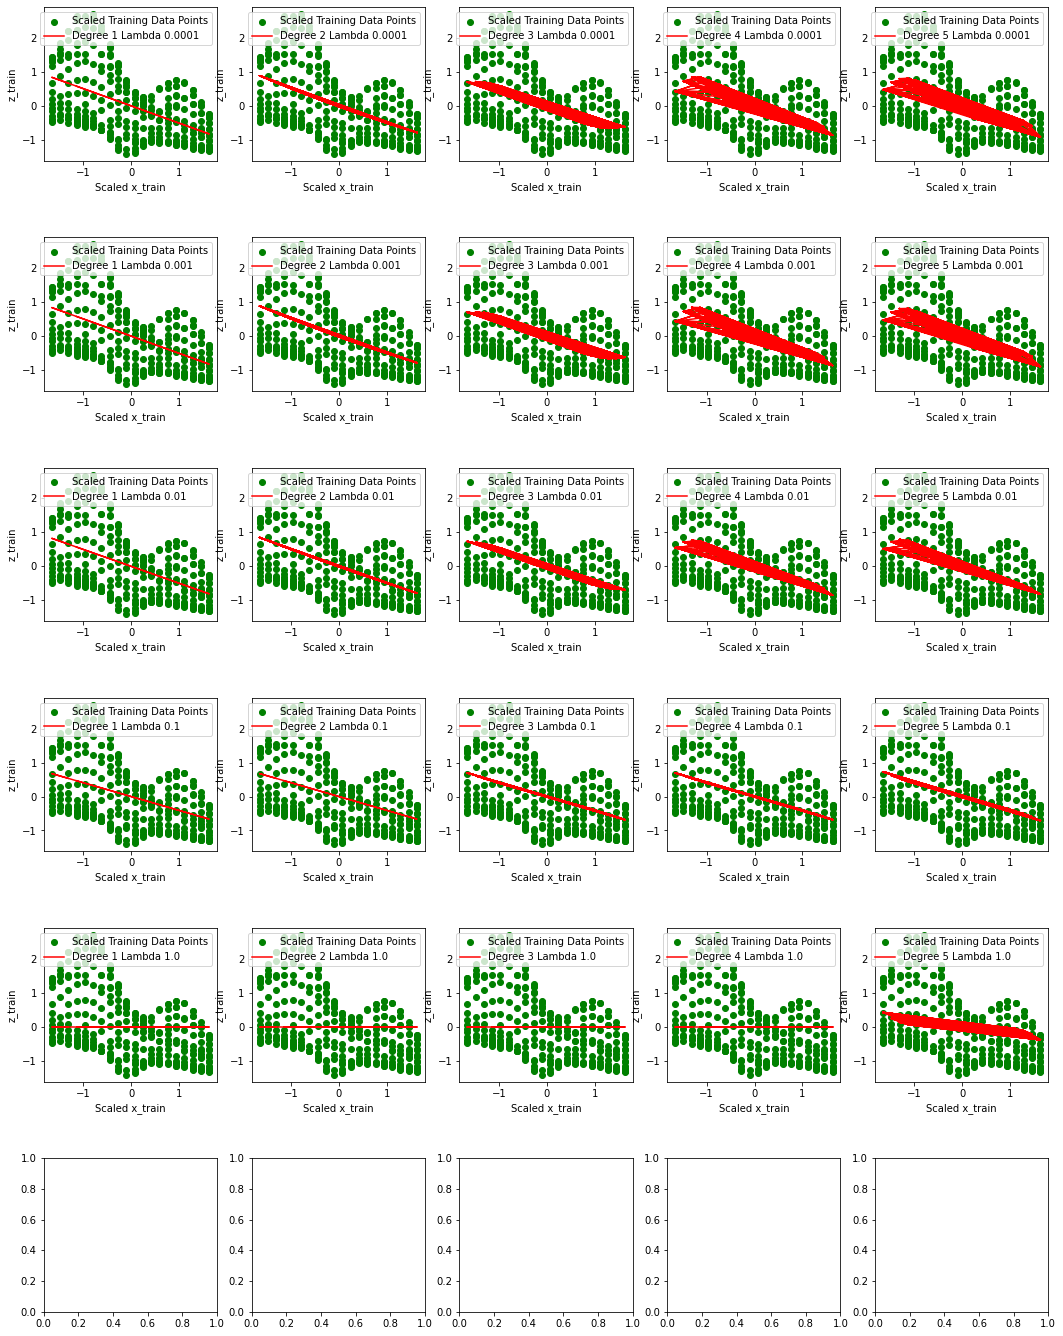

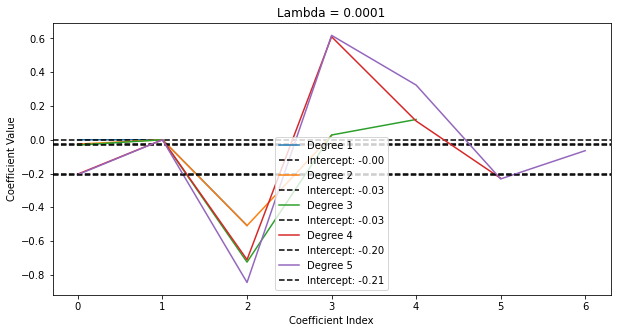

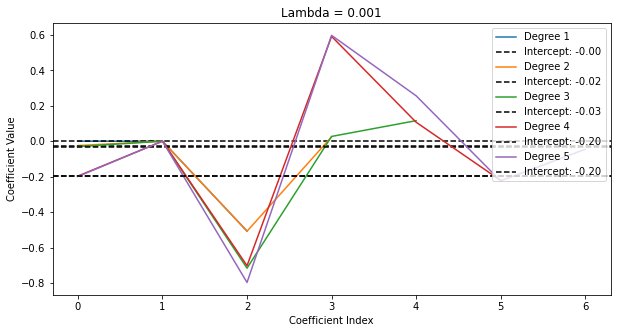

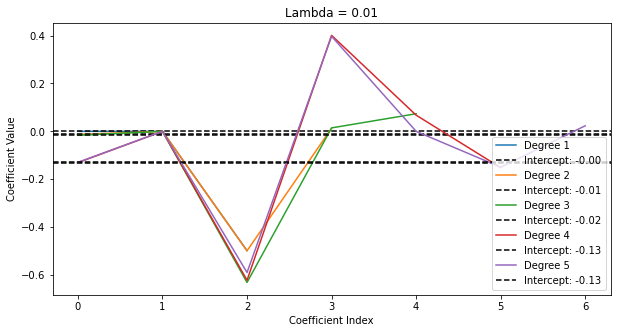

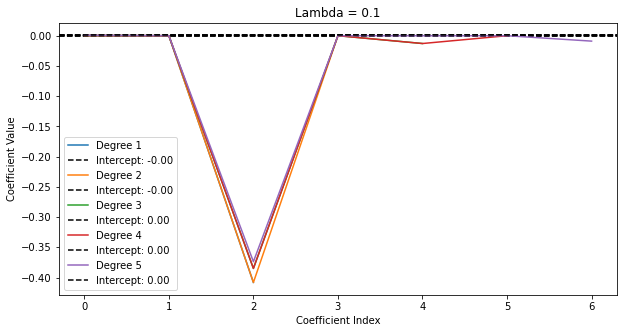

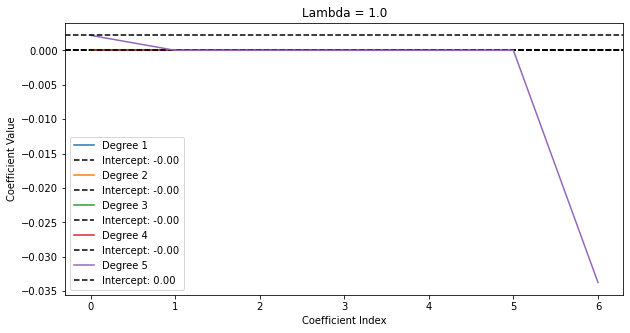

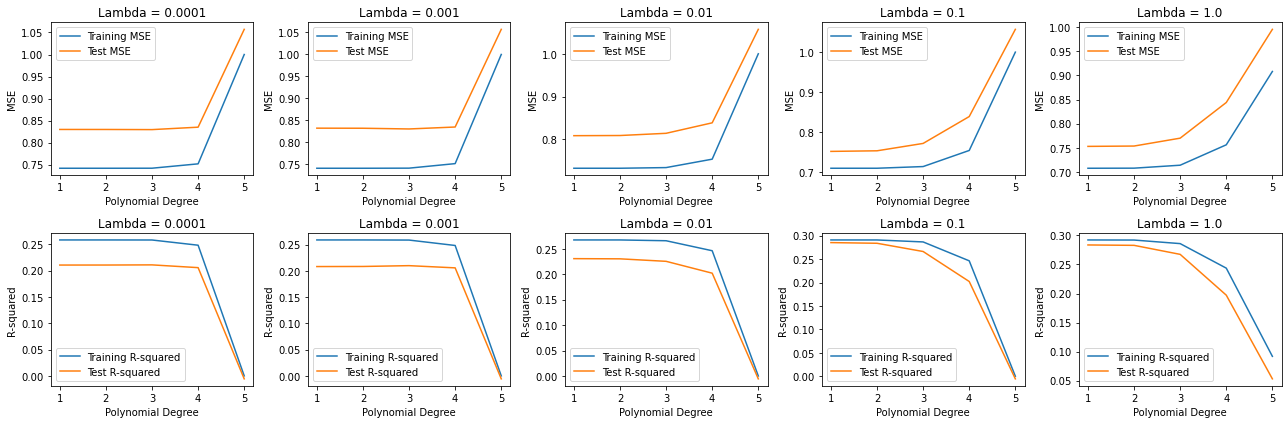

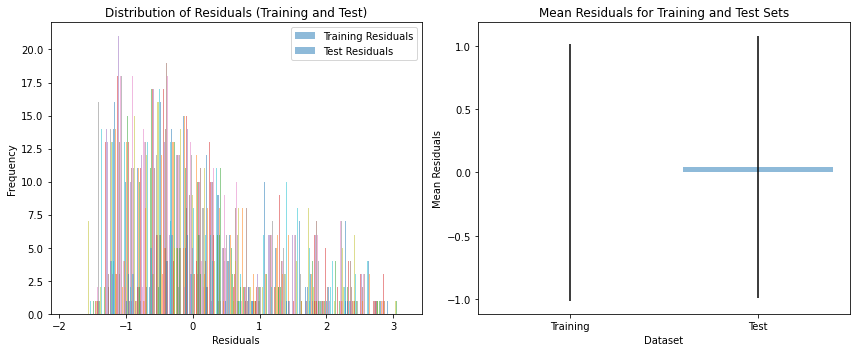

In [3]:
#Code including the Polynomial Fits for Lasso on the original Franke Function: 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Define the Franke function
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

# Generate data using the Franke function
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)

# Flatten the 2D arrays for data splitting
x_flat = x.ravel()
y_flat = y.ravel()
z_flat = z.ravel()

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_flat, y_flat, z_flat, test_size=0.2, random_state=42)

# Scale the data using StandardScaler for both input features and target variable
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train.reshape(-1, 1))
x_test_scaled = scaler_x.transform(x_test.reshape(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
z_train_scaled = scaler_y.fit_transform(z_train.reshape(-1, 1))  # Also standardize the target variable
z_test_scaled = scaler_y.transform(z_test.reshape(-1, 1))

# Initialize lists to store MSE and R-squared values for different degrees and lambda values (Lasso parameter)
degree_range = range(1, 6)
lambda_values = [0.0001, 0.001, 0.01, 0.1, 1.0]

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
beta_coefficients_list = []

# Create subplots for the scaled training and test data
fig, axs = plt.subplots(6, len(degree_range), figsize=(18, 24))
fig.subplots_adjust(hspace=0.5)

for i, lambda_val in enumerate(lambda_values):
    for degree in degree_range:
        # Create polynomial features for the current degree
        X_train = np.ones_like(x_train_scaled)
        X_test = np.ones_like(x_test_scaled)

        for d in range(1, degree + 1):
            X_train = np.hstack((X_train, x_train_scaled**d))
            X_test = np.hstack((X_test, x_test_scaled**d))

        # Fit Lasso regression model with the current lambda
        model = Lasso(alpha=lambda_val)
        model.fit(X_train, z_train_scaled)

        z_train_pred = model.predict(X_train)
        z_test_pred = model.predict(X_test)

        mse_train = mean_squared_error(z_train_scaled, z_train_pred)
        mse_test = mean_squared_error(z_test_scaled, z_test_pred)
        r2_train = r2_score(z_train_scaled, z_train_pred)
        r2_test = r2_score(z_test_scaled, z_test_pred)

        mse_train_list.append(mse_train)
        mse_test_list.append(mse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

        # Store beta coefficients, including the intercept
        beta_coeffs = np.insert(model.coef_, 0, model.intercept_)
        beta_coefficients_list.append(beta_coeffs)

        # Plot the scaled training and test data for each degree and lambda
        axs[i, degree - 1].scatter(x_train_scaled, z_train_scaled, label='Scaled Training Data Points', color='green')
        z_pred_train = model.predict(X_train)
        axs[i, degree - 1].plot(x_train_scaled, z_pred_train, color='red', label=f'Degree {degree} Lambda {lambda_val}')
        axs[i, degree - 1].set_xlabel('Scaled x_train')
        axs[i, degree - 1].set_ylabel('z_train')
        axs[i, degree - 1].legend()

# Plot beta coefficients for each lambda value and degree
for i, lambda_val in enumerate(lambda_values):
    plt.figure(figsize=(10, 5))
    for degree in degree_range:
        beta_coeffs_lasso = beta_coefficients_list[i * len(degree_range) + degree - 1]
        intercept = beta_coeffs_lasso[0]  # Intercept is at index 0
        plt.plot(range(len(beta_coeffs_lasso)), beta_coeffs_lasso, label=f'Degree {degree}')
        plt.axhline(y=intercept, color='black', linestyle='--', label=f'Intercept: {intercept:.2f}')
    plt.title(f'Lambda = {lambda_val}')
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.legend()
    plt.show()

# MSE and R-squared plots
plt.figure(figsize=(18, 6))
for i, lambda_val in enumerate(lambda_values):
    plt.subplot(2, len(lambda_values), i + 1)
    plt.plot(degree_range, mse_train_list[i::len(lambda_values)], label='Training MSE')
    plt.plot(degree_range, mse_test_list[i::len(lambda_values)], label='Test MSE')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('MSE')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

    plt.subplot(2, len(lambda_values), len(lambda_values) + i + 1)
    plt.plot(degree_range, r2_train_list[i::len(lambda_values)], label='Training R-squared')
    plt.plot(degree_range, r2_test_list[i::len(lambda_values)], label='Test R-squared')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('R-squared')
    plt.title(f'Lambda = {lambda_val}')
    plt.legend()

plt.tight_layout()
plt.show()

# Calculate and analyze error terms
residuals_train = z_train_scaled - z_train_pred
residuals_test = z_test_scaled - z_test_pred

# Calculate mean and standard deviation of residuals
mean_residuals_train = np.mean(residuals_train)
std_residuals_train = np.std(residuals_train)

mean_residuals_test = np.mean(residuals_test)
std_residuals_test = np.std(residuals_test)

# Plot histograms of residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=50, label='Training Residuals', alpha=0.5)
plt.hist(residuals_test, bins=50, label='Test Residuals', alpha=0.5)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Residuals (Training and Test)')

plt.subplot(1, 2, 2)
plt.bar(['Training', 'Test'], [mean_residuals_train, mean_residuals_test], yerr=[std_residuals_train, std_residuals_test], alpha=0.5)
plt.xlabel('Dataset')
plt.ylabel('Mean Residuals')
plt.title('Mean Residuals for Training and Test Sets')

plt.tight_layout()
plt.show()


#Results: From the data plots, we see that for lambda = 0.0001 (Containing the least regularization), the bias is
#quite high for all degree polynomials. We also see that the variance increases as the polynomial degree increases,
#and the variance for the degree 5 polynomial is quite high. #For lambda = 0.001, the results are more or less consistent
#with lambda = 0.0001. For lambda = 0.01, the bias is still quite large, but the variance is not as large. However,
#still the variance increases as polynomial degrees increase. #The same holds for lambda = 0.1, and the variance is 
#even smaller. For lambda=1, there is close to no bias, and for degree 1-4, there is no variance. For degree 5 however,
#there is some variance. 

#Interpretation: The predictions become less accurate as the amount of regularization in the model
#decreases. So obviously regularization is good for accuracy in the Lasso regression. 
#The variance in the predictions also becomes larger as the polynomial degree increases, which is as expected,
#because the model complexity increases, making it harder to hit the accurate points on the graph. 

#Who performed best? At the two lowest lambda-values, with the least regularization, the Ridge and Lasso
#performed equally. For the other lambda-values, Lasso method generated polynomial fits of predicted values
#that had less bias and variance as the lambda-value got higher, even though the bias and variance increased
#a tiny bit as the polynomial degree was higher. Overall, Lasso performed clearly better than Ridge, which
#performed clearly better than OLS.
